<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S6/EVAS6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libs


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [2]:
!pip install torchsummary

In [0]:
from torchsummary import summary

## Transforms/Reading Dataset

In [0]:
train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)

In [6]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.13054245710372925
Training Dataset Mean: 0.30810782313346863


In [7]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.13054245710372925
Testing Dataset Mean: 0.3104802668094635


In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,),(0.308,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])

In [5]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
#print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
#print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

In [7]:
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

Testing Dataset Mean: 0.0064513590186834335
Testing Dataset Mean: 1.0080528259277344


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Defining Data Loader


In [0]:
# defining the seed for reproducible
SEED = 99

torch.manual_seed(SEED)

# checking if the CUDA is available 

is_CUDA = torch.cuda.is_available()

if is_CUDA:
  dev = torch.device('cuda')
else:
  dev = torch.device('cpu')



In [0]:
BATCH_SIZE=128
EPOCHS=15

In [0]:
dataloader_args = dict(shuffle=True,batch_size=BATCH_SIZE,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=True,batch_size=BATCH_SIZE//2)
train_dl = DataLoader(train_data,**dataloader_args)

dataloader_args = dict(shuffle=False,batch_size=BATCH_SIZE*2,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=False,batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data,**dataloader_args)

In [0]:
x,y=next(iter(train_dl))

In [12]:
x.size(),y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [0]:
torch.Tensor.stats = lambda x: (x.mean(),x.std())

In [14]:
x.stats()

(tensor(0.0284), tensor(1.0290))

In [15]:
type(x)

torch.Tensor

In [20]:
train_dl.dataset.transforms

StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-5.0, 5.0), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.1305,), std=(0.308,))
           )

## Visualizing the data

In [0]:
def plot_img(img,axs=None,figsize=(6,6),visible=True):
  if axs is None:
    _,axs=plt.subplots(1,1,figsize=figsize)
  if not visible:
    #print("yesy")
    axs.set_xticks([])
    axs.set_yticks([])
  axs.imshow(img.numpy().squeeze(0),cmap='gray_r')
  
  

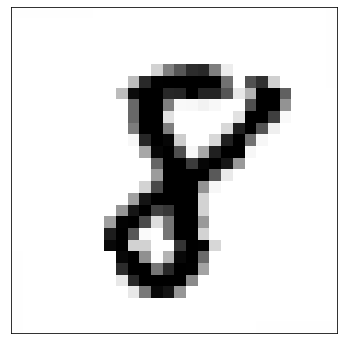

In [22]:
plot_img(x[0],visible=False)

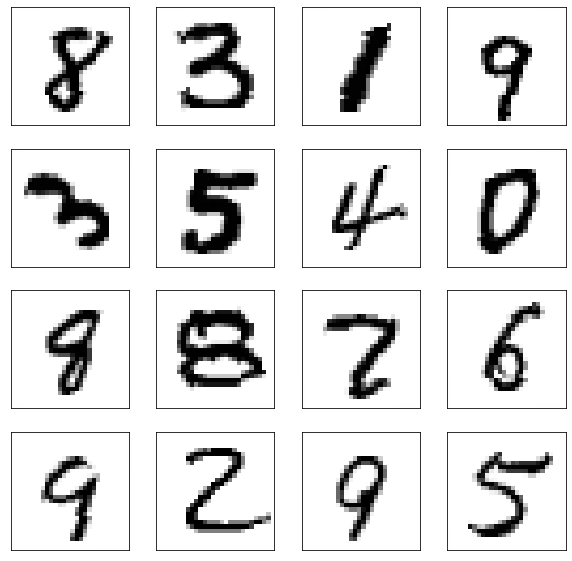

In [23]:
fig,axs = plt.subplots(4,4,figsize=(10,10))
for i,ax in enumerate(axs.ravel()):
  plot_img(x[i],axs=axs[i//4,i%4],visible=False)

## Defining Model

In [0]:
class Model(nn.Module):
  def __init__(self,p=0.1,use_bias=True):
    super().__init__()
    self.alllyrs=nn.Sequential()
    cblock1 = []
    cblock1.append(nn.Sequential(*[nn.Conv2d(1,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=26,RF=3
    cblock1.append(nn.Sequential(*[nn.Conv2d(12,24,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(24),nn.ReLU(),nn.Dropout(p=p)])) # output_size=24,RF=5
    self.cblock1 = nn.Sequential(*cblock1)
    tblock1=[]
    tblock1.append(nn.MaxPool2d((2,2))) # output_size=12, RF=6
    tblock1.append(nn.Sequential(*[nn.Conv2d(24,12,kernel_size=(1,1),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=12,RF=6
    self.tblock1=nn.Sequential(*tblock1)
    cblock2 = []
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=10,RF=10
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=8,RF=14
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=6,RF=18
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=4,RF=22
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=4,RF=26

    self.cblock2 = nn.Sequential(*cblock2)
    tblock2=[]
    tblock2.append(nn.AdaptiveAvgPool2d((1,1)))
    tblock2.append(nn.Conv2d(12,10,kernel_size=(1,1),stride=1))
    self.tblock2=nn.Sequential(*tblock2)
  def forward(self,x):
    x = self.cblock1(x)
    x = self.tblock1(x)
    x = self.cblock2(x)
    x = self.tblock2(x)
    return F.log_softmax(x).squeeze().squeeze()


In [0]:
mod=Model(use_bias=False).cuda()

In [0]:
#mod

In [19]:
summary(model=mod,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,592
       BatchNorm2d-6           [-1, 24, 24, 24]              48
              ReLU-7           [-1, 24, 24, 24]               0
           Dropout-8           [-1, 24, 24, 24]               0
         MaxPool2d-9           [-1, 24, 12, 12]               0
           Conv2d-10           [-1, 12, 12, 12]             288
      BatchNorm2d-11           [-1, 12, 12, 12]              24
             ReLU-12           [-1, 12, 12, 12]               0
          Dropout-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training Loop Design

In [0]:
# basic loop structure

def one_epoch(model,trn_dl,val_dl,opt,device='cpu'):
  # variables to keep track off during one epoch
  bcount=0
  tlosses=[]
  overall_tloss=0
  tacc=0
  # put model in training mode
  model.train()
  # define a progress bar
  pbar = tqdm(trn_dl)
  # loop through every batch in dataloader
  for batch_index,(xb,yb) in enumerate(pbar):
    # move the data to cpu or gpu based on device arg
    xb,yb=xb.to(device),yb.to(device)
    bs = xb.shape[0]
    # clean the gradients of parameters computed in the previous batch
    opt.zero_grad()
    # predict the batch
    preds = model(xb)
    # compute batch loss
    loss = F.nll_loss(preds,yb)
    # append the current loss to list
    tlosses.append(loss.item())
    overall_tloss+=loss*bs
    # call back propagation
    loss.backward()
    # call the optimization step
    opt.step()
    # compute the current model accuracy
    y_preds=preds.argmax(dim=1,keepdim=True)
    # compute current accuracy of the training batch and add it to the total count of accurate results
    tacc+= y_preds.eq(yb.view_as(y_preds)).sum().item()
    bcount+=bs
    # add progress bar description with current batch loss and moving average of training accuracy
    pbar.set_description(desc=f'Loss={loss.item():.3f} batch-index={batch_index} Accuracy={100*tacc/bcount:0.2f}')
  
  # compute the updated training loss and accuracy for entire batch
  overall_tloss/=bcount
  tacc/=bcount

  # loop through validation data and compute the metrics on validation data
  model.eval()
  vlosses=[]
  overall_vloss=0
  vacc=0
  vcount=0
  with torch.no_grad():
    for xb,yb in tqdm(val_dl):
      bs = xb.shape[0]
      xb,yb = xb.to(device),yb.to(device)
      preds = model(xb)
      loss = F.nll_loss(preds,yb,reduction='sum')
      vlosses.append(loss/bs)
      y_preds = preds.argmax(dim=1,keepdim=True)
      vacc+=y_preds.eq(yb.view_as(y_preds)).sum().item()
      vcount+=bs
      overall_vloss+=loss.item()
  overall_vloss/=vcount
  vacc/=vcount
  return {'TrainingLoss':overall_tloss,'ValidationLoss':overall_vloss,'TrainingAcc':tacc,'ValidationAcc':vacc,'Tlosses':tlosses,'Vlosses':vlosses}








## Training the Model -- No regularization

In [19]:
EPOCHS=40
mod=Model(p=0.05,use_bias=False).cuda()
opt = optim.SGD(mod.parameters(),lr=0.1,momentum=0.9)
scheduler = StepLR(opt, step_size=5, gamma=0.3)
tlosses_batchwise=[]
vlosses_batchwise=[]
tlosses_epochwise=[]
vlosses_epochwise=[]
tacc_epochwise=[]
vacc_epochwise=[]

for e in range(EPOCHS):
  ldict=one_epoch(mod,train_dl,test_dl,opt,device=dev)
  scheduler.step()
  if e%5==0:
    print(f"\nCurrent Learning Rate: {opt.param_groups[-1]['lr']}")
  print(f'\nEpoch:{e}--> Training Loss:{ldict["TrainingLoss"]:.3f}, Validation Loss:{ldict["ValidationLoss"]:.3f}\n')
  print(f'Training Accuracy:{100*ldict["TrainingAcc"]:.3f}, Validation Accuracy:{100*ldict["ValidationAcc"]:.3f}\n')
  tlosses_batchwise.extend(ldict['Tlosses'])
  vlosses_batchwise.extend(ldict['Vlosses'])
  tlosses_epochwise.append(ldict['TrainingLoss'])
  vlosses_epochwise.append(ldict['ValidationLoss'])
  tacc_epochwise.append(ldict['TrainingAcc'])
  vacc_epochwise.append(ldict['ValidationAcc'])

  

  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.1

Epoch:0--> Training Loss:0.327, Validation Loss:0.066

Training Accuracy:89.855, Validation Accuracy:97.990



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.078, Validation Loss:0.038

Training Accuracy:97.720, Validation Accuracy:98.770



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.060, Validation Loss:0.035

Training Accuracy:98.147, Validation Accuracy:98.870



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.052, Validation Loss:0.033

Training Accuracy:98.410, Validation Accuracy:98.970



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.047, Validation Loss:0.032

Training Accuracy:98.528, Validation Accuracy:99.030



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.036, Validation Loss:0.023

Training Accuracy:98.918, Validation Accuracy:99.290



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.034, Validation Loss:0.023

Training Accuracy:98.967, Validation Accuracy:99.270



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.032, Validation Loss:0.023

Training Accuracy:99.007, Validation Accuracy:99.240



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.032, Validation Loss:0.023

Training Accuracy:99.003, Validation Accuracy:99.350



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.030, Validation Loss:0.023

Training Accuracy:99.103, Validation Accuracy:99.290



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:10--> Training Loss:0.027, Validation Loss:0.023

Training Accuracy:99.140, Validation Accuracy:99.380



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.026, Validation Loss:0.022

Training Accuracy:99.152, Validation Accuracy:99.350



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.026, Validation Loss:0.022

Training Accuracy:99.185, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.028, Validation Loss:0.021

Training Accuracy:99.157, Validation Accuracy:99.380



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.027, Validation Loss:0.022

Training Accuracy:99.162, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:15--> Training Loss:0.026, Validation Loss:0.022

Training Accuracy:99.195, Validation Accuracy:99.340



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.205, Validation Accuracy:99.380



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.230, Validation Accuracy:99.400



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.213, Validation Accuracy:99.390



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.212, Validation Accuracy:99.380



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.0008099999999999998

Epoch:20--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.218, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.218, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.243, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.252, Validation Accuracy:99.340



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.298, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.00024299999999999994

Epoch:25--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.250, Validation Accuracy:99.380



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.277, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.262, Validation Accuracy:99.400



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.247, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.238, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 7.289999999999998e-05

Epoch:30--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.247, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.282, Validation Accuracy:99.400



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.253, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.025, Validation Loss:0.022

Training Accuracy:99.203, Validation Accuracy:99.410



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.230, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 2.1869999999999996e-05

Epoch:35--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.300, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.024, Validation Loss:0.022

Training Accuracy:99.230, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.220, Validation Accuracy:99.370



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.248, Validation Accuracy:99.390



100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


Epoch:39--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.262, Validation Accuracy:99.370



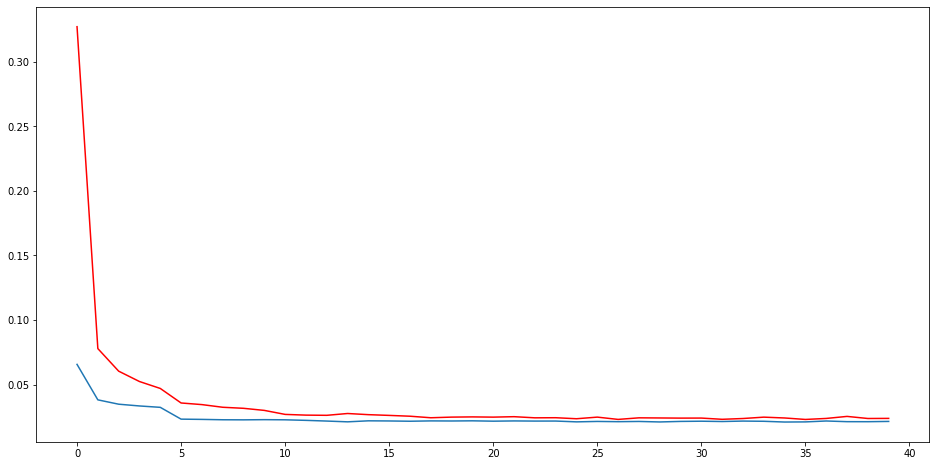

In [28]:
plt.figure(figsize=(16,8))
plt.plot(vlosses_epochwise)
plt.plot(tlosses_epochwise,c='r')
plt.show()

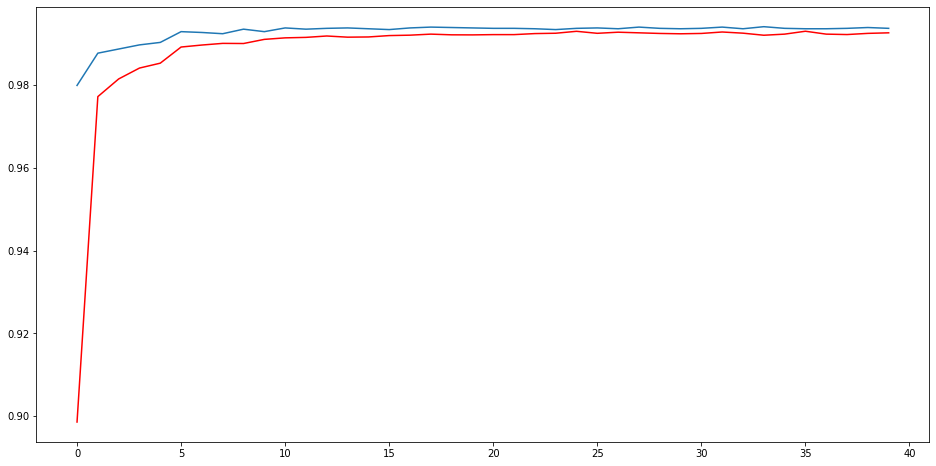

In [30]:
plt.figure(figsize=(16,8))
plt.plot(vacc_epochwise)
plt.plot(tacc_epochwise,c='r')
plt.show()

In [32]:
np.min(vacc_epochwise)

0.9799

In [33]:
vacc_epochwise[-1]

0.9937

## Weights histogram

Before we attempt any regularization, its good to get some sense of weight distribution in the model without regularisation

In [0]:
params = list(mod.parameters())

In [36]:
params[0].size()

torch.Size([12, 1, 3, 3])

In [0]:
plist=[]
for p in params:
  plist.extend(p.view(-1,).cpu().detach().numpy().tolist())

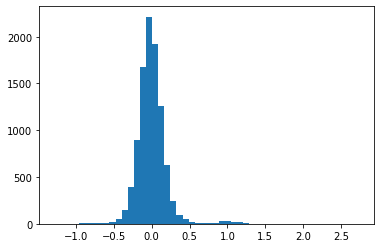

In [48]:
plt.hist(plist,bins=50)
plt.show()

In [49]:
np.max(plist),np.min(plist)

(2.7362892627716064, -1.2804921865463257)

Weights seems to be centered around 0 with range between ~ -1.3 to 2.8

Let's try to get intuition about how the mean of weight is changing w.r.t layers. The range and std of weights changing w.r.t layer 

In [0]:
conv_weights = [p.cpu().detach().numpy() for p in params[::3]]


In [79]:
[p.shape for p in conv_weights]

[(12, 1, 3, 3),
 (24, 12, 3, 3),
 (12, 24, 1, 1),
 (12, 12, 3, 3),
 (12, 12, 3, 3),
 (12, 12, 3, 3),
 (12, 12, 3, 3),
 (12, 12, 3, 3),
 (10, 12, 1, 1)]

In [0]:
weight_mean = [np.mean(p) for p in conv_weights]
weight_std = [np.std(p) for p in conv_weights]
weight_range = [np.max(p)-np.min(p) for p in conv_weights]

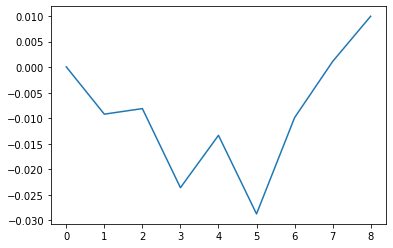

In [84]:
plt.plot(weight_mean)

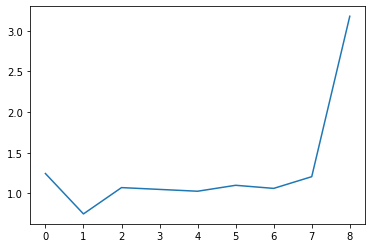

In [85]:
plt.plot(weight_range)

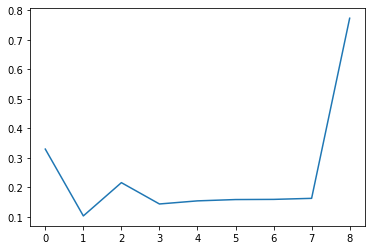

In [86]:
plt.plot(weight_std)

## L1 regularization

### Three ways to implement L1 loss

In [103]:
l1_crit=nn.L1Loss(size_average=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
t = torch.randn(100,100)

In [108]:
t.abs().sum()

tensor(8040.9448)

In [111]:
l1_crit(t,torch.full_like(t,0))

tensor(8040.9448)

In [0]:
xb,yb = next(iter(train_dl))
xb,yb = xb.to(dev),yb.to(dev)

In [128]:

preds = mod(xb)
loss = F.nll_loss(preds,yb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [138]:
l1_crit = nn.L1Loss(size_average=False)
reg_loss1 = 0
for param in mod.parameters():
        reg_loss1 += l1_crit(param,torch.full_like(param,0))

factor = 0.0005
nloss1 = loss + factor * reg_loss1

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
opt.zero_grad()
nloss1.backward()

In [0]:
g1=params[0].grad.data.cpu()

In [151]:

preds = mod(xb)
loss = F.nll_loss(preds,yb)
reg_loss2 = 0
for param in mod.parameters():
        reg_loss += param.abs().sum()

factor = 0.0005
nloss2 = loss + factor * reg_loss2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
opt.zero_grad()
nloss2.backward()

In [0]:
g2=params[0].grad.data.cpu()

In [157]:
g2.min(),g1.min()

(tensor(-0.0113), tensor(-0.0108))

In [158]:

preds = mod(xb)
loss = F.nll_loss(preds,yb)
reg_loss3 = 0
for param in mod.parameters():
        reg_loss += param.norm(1)

factor = 0.0005
nloss3 = loss + factor * reg_loss2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
opt.zero_grad()
nloss3.backward()

In [0]:
g3=params[0].grad.data.cpu()

In [161]:
g2.min(),g1.min(),g3.min()

(tensor(-0.0113), tensor(-0.0108), tensor(-0.0113))

In [162]:
g2.max(),g1.max(),g3.max()

(tensor(0.0165), tensor(0.0170), tensor(0.0165))

### Applying L1 regularization to baseline model

In [0]:
# basic loop structure

def one_epoch_l1(model,trn_dl,val_dl,opt,device='cpu',alpha=1e-8):
  # variables to keep track off during one epoch
  bcount=0
  tloss=0
  tloss_penalty=0
  tacc=0
  def compute_l1():
    reg_l1 = 0
    for p in model.parameters():
      reg_l1+=p.norm(1)
    return reg_l1
  # put model in training mode
  model.train()
  # define a progress bar
  pbar = tqdm(trn_dl)
  # loop through every batch in dataloader
  for batch_index,(xb,yb) in enumerate(pbar):
    # move the data to cpu or gpu based on device arg
    xb,yb=xb.to(device),yb.to(device)
    bs = xb.shape[0]
    # clean the gradients of parameters computed in the previous batch
    opt.zero_grad()
    # predict the batch
    preds = model(xb)
    # compute batch loss
    loss = F.nll_loss(preds,yb)
    # add the l1 penalty
    loss_penalty = loss + alpha*compute_l1()
    # append the current loss to list
    tloss+=loss*bs
    tloss_penalty+=loss_penalty*bs
    # call back propagation
    loss_penalty.backward()
    # call the optimization step
    opt.step()
    # compute the current model accuracy
    y_preds=preds.argmax(dim=1,keepdim=True)
    # compute current accuracy of the training batch and add it to the total count of accurate results
    tacc+= y_preds.eq(yb.view_as(y_preds)).sum().item()
    bcount+=bs
    # add progress bar description with current batch loss and moving average of training accuracy
    pbar.set_description(desc=f'Loss={loss.item():.3f} batch-index={batch_index} Accuracy={100*tacc/bcount:0.2f}')
  
  # compute the updated training loss and accuracy for entire batch
  tloss/=bcount
  tloss_penalty/=bcount
  tacc/=bcount

  # loop through validation data and compute the metrics on validation data
  model.eval()
  vlosses=[]
  overall_vloss=0
  vacc=0
  vcount=0
  with torch.no_grad():
    for xb,yb in tqdm(val_dl):
      bs = xb.shape[0]
      xb,yb = xb.to(device),yb.to(device)
      preds = model(xb)
      loss = F.nll_loss(preds,yb,reduction='sum')
      vlosses.append(loss/bs)
      y_preds = preds.argmax(dim=1,keepdim=True)
      vacc+=y_preds.eq(yb.view_as(y_preds)).sum().item()
      vcount+=bs
      overall_vloss+=loss.item()
  overall_vloss/=vcount
  vacc/=vcount
  return {'TrainingLoss':tloss,'ValidationLoss':overall_vloss,'TrainingAcc':tacc,'ValidationAcc':vacc,'TrainingLossWithL1':tloss_penalty,'VLosses':vlosses}








In [26]:
torch.save(mod.state_dict(),'baseline_mod')

NameError: ignored

In [22]:
# applying l1=1e-4
%%time
def train(epochs=40,l1=1e-4,l2=0):
  EPOCHS=epochs
  mod=Model(p=0.05,use_bias=False).cuda()
  opt = optim.SGD(mod.parameters(),lr=0.03,momentum=0.9,weight_decay=l2)
  scheduler = StepLR(opt, step_size=epochs//3, gamma=0.3)
  #vlosses_batchwise=[]
  tlosses_epochwise=[]
  vlosses_epochwise=[]
  tacc_epochwise=[]
  vacc_epochwise=[]

  for e in range(EPOCHS):
    ldict=one_epoch_l1(mod,train_dl,test_dl,opt,device=dev,alpha=l1)
    scheduler.step()
    if e%5==0:
      print(f"\nCurrent Learning Rate: {opt.param_groups[-1]['lr']}")
    print(f'\nEpoch:{e}--> Training Loss:{ldict["TrainingLoss"]:.3f}, Validation Loss:{ldict["ValidationLoss"]:.3f}\n')
    print(f'Training Accuracy:{100*ldict["TrainingAcc"]:.3f}, Validation Accuracy:{100*ldict["ValidationAcc"]:.3f}\n')
    tlosses_epochwise.append(ldict['TrainingLoss'])
    vlosses_epochwise.append(ldict['ValidationLoss'])
    tacc_epochwise.append(ldict['TrainingAcc'])
    vacc_epochwise.append(ldict['ValidationAcc'])
  return {'model':mod.state_dict(),'TrainingLosses':tlosses_epochwise,'ValidationLosses':vlosses_epochwise,'TrainingAcc':tacc_epochwise,'ValidationAcc':vacc_epochwise}

  

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [29]:
%%time 
trained_models={}
for regl in [0,1e-5,1e-4,1e-3,1e-2]:
  trained_models[str(regl)]=train(epochs=40,l1=regl)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.317, Validation Loss:0.066

Training Accuracy:90.863, Validation Accuracy:97.920



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.073, Validation Loss:0.046

Training Accuracy:97.790, Validation Accuracy:98.610



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.059, Validation Loss:0.033

Training Accuracy:98.220, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.050, Validation Loss:0.028

Training Accuracy:98.462, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.045, Validation Loss:0.032

Training Accuracy:98.642, Validation Accuracy:99.050



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.043, Validation Loss:0.026

Training Accuracy:98.702, Validation Accuracy:99.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.040, Validation Loss:0.028

Training Accuracy:98.802, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.038, Validation Loss:0.026

Training Accuracy:98.857, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.037, Validation Loss:0.025

Training Accuracy:98.860, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.034, Validation Loss:0.021

Training Accuracy:98.945, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.033, Validation Loss:0.023

Training Accuracy:99.015, Validation Accuracy:99.250



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.032, Validation Loss:0.024

Training Accuracy:98.988, Validation Accuracy:99.280



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.032, Validation Loss:0.025

Training Accuracy:98.983, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.227, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.278, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.295, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.302, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.022, Validation Loss:0.022

Training Accuracy:99.303, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.302, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.021, Validation Loss:0.020

Training Accuracy:99.357, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.020, Validation Loss:0.021

Training Accuracy:99.375, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.021, Validation Loss:0.020

Training Accuracy:99.375, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.021, Validation Loss:0.020

Training Accuracy:99.345, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.380, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.385, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.380, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.452, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.018, Validation Loss:0.020

Training Accuracy:99.452, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.420, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.017, Validation Loss:0.019

Training Accuracy:99.443, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.430, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.425, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.017, Validation Loss:0.018

Training Accuracy:99.477, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.017, Validation Loss:0.019

Training Accuracy:99.478, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.017, Validation Loss:0.020

Training Accuracy:99.455, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.017, Validation Loss:0.018

Training Accuracy:99.503, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.017, Validation Loss:0.019

Training Accuracy:99.478, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.480, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.017, Validation Loss:0.020

Training Accuracy:99.470, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.017, Validation Loss:0.019

Training Accuracy:99.467, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.298, Validation Loss:0.055

Training Accuracy:91.633, Validation Accuracy:98.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.074, Validation Loss:0.036

Training Accuracy:97.768, Validation Accuracy:98.780



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.058, Validation Loss:0.036

Training Accuracy:98.198, Validation Accuracy:98.830



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.029

Training Accuracy:98.398, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.048, Validation Loss:0.028

Training Accuracy:98.535, Validation Accuracy:99.060



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.042, Validation Loss:0.026

Training Accuracy:98.730, Validation Accuracy:99.180



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.042, Validation Loss:0.026

Training Accuracy:98.722, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.038, Validation Loss:0.025

Training Accuracy:98.815, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.039, Validation Loss:0.027

Training Accuracy:98.835, Validation Accuracy:99.200



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.036, Validation Loss:0.025

Training Accuracy:98.912, Validation Accuracy:99.130



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.034, Validation Loss:0.024

Training Accuracy:98.978, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.032, Validation Loss:0.026

Training Accuracy:99.000, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.032, Validation Loss:0.024

Training Accuracy:98.987, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.265, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.283, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.230, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.255, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.262, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.325, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.021, Validation Loss:0.017

Training Accuracy:99.330, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.318, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.318, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.333, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.328, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.021, Validation Loss:0.019

Training Accuracy:99.355, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.021, Validation Loss:0.018

Training Accuracy:99.348, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.378, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.460, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.433, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.402, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.397, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.412, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.455, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.455, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.415, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.017, Validation Loss:0.017

Training Accuracy:99.470, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.415, Validation Accuracy:99.540



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.448, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.488, Validation Accuracy:99.560



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.488, Validation Accuracy:99.540



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.293, Validation Loss:0.048

Training Accuracy:91.850, Validation Accuracy:98.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.081, Validation Loss:0.041

Training Accuracy:97.573, Validation Accuracy:98.680



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.069, Validation Loss:0.050

Training Accuracy:97.950, Validation Accuracy:98.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.058, Validation Loss:0.029

Training Accuracy:98.293, Validation Accuracy:99.150



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.056, Validation Loss:0.033

Training Accuracy:98.272, Validation Accuracy:98.840



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.055, Validation Loss:0.034

Training Accuracy:98.307, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.052, Validation Loss:0.030

Training Accuracy:98.430, Validation Accuracy:99.020



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.052, Validation Loss:0.037

Training Accuracy:98.365, Validation Accuracy:98.940



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.049, Validation Loss:0.031

Training Accuracy:98.517, Validation Accuracy:99.070



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.050, Validation Loss:0.035

Training Accuracy:98.495, Validation Accuracy:98.990



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.050, Validation Loss:0.033

Training Accuracy:98.480, Validation Accuracy:98.910



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.045, Validation Loss:0.030

Training Accuracy:98.602, Validation Accuracy:99.080



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.046, Validation Loss:0.031

Training Accuracy:98.623, Validation Accuracy:98.940



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.034, Validation Loss:0.019

Training Accuracy:98.962, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.032, Validation Loss:0.021

Training Accuracy:99.028, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.030, Validation Loss:0.019

Training Accuracy:99.112, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.029, Validation Loss:0.020

Training Accuracy:99.152, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.043, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.030, Validation Loss:0.021

Training Accuracy:99.110, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.030, Validation Loss:0.021

Training Accuracy:99.133, Validation Accuracy:99.300



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.032, Validation Loss:0.020

Training Accuracy:99.005, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.031, Validation Loss:0.021

Training Accuracy:99.088, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.038, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.032, Validation Loss:0.020

Training Accuracy:98.998, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.033, Validation Loss:0.020

Training Accuracy:98.978, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:98.967, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.026, Validation Loss:0.019

Training Accuracy:99.198, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.260, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.282, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.245, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.278, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.268, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.237, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.257, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.317, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.297, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.315, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.288, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.280, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.021, Validation Loss:0.017

Training Accuracy:99.367, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.340, Validation Loss:0.126

Training Accuracy:90.105, Validation Accuracy:96.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.132, Validation Loss:0.155

Training Accuracy:96.023, Validation Accuracy:95.300



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.121, Validation Loss:0.119

Training Accuracy:96.473, Validation Accuracy:96.550



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.123, Validation Loss:0.111

Training Accuracy:96.322, Validation Accuracy:96.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.118, Validation Loss:0.120

Training Accuracy:96.533, Validation Accuracy:96.280



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.117, Validation Loss:0.099

Training Accuracy:96.457, Validation Accuracy:97.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.118, Validation Loss:0.077

Training Accuracy:96.478, Validation Accuracy:97.690



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.121, Validation Loss:0.077

Training Accuracy:96.393, Validation Accuracy:97.690



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.124, Validation Loss:0.127

Training Accuracy:96.408, Validation Accuracy:95.940



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.118, Validation Loss:0.081

Training Accuracy:96.523, Validation Accuracy:97.670



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.122, Validation Loss:0.116

Training Accuracy:96.360, Validation Accuracy:96.750



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.117, Validation Loss:0.084

Training Accuracy:96.503, Validation Accuracy:97.600



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.119, Validation Loss:0.109

Training Accuracy:96.398, Validation Accuracy:96.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.075, Validation Loss:0.054

Training Accuracy:97.793, Validation Accuracy:98.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.080, Validation Loss:0.061

Training Accuracy:97.642, Validation Accuracy:98.290



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.089, Validation Loss:0.058

Training Accuracy:97.340, Validation Accuracy:98.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.089, Validation Loss:0.060

Training Accuracy:97.370, Validation Accuracy:98.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.089, Validation Loss:0.048

Training Accuracy:97.428, Validation Accuracy:98.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.091, Validation Loss:0.055

Training Accuracy:97.317, Validation Accuracy:98.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.092, Validation Loss:0.041

Training Accuracy:97.360, Validation Accuracy:98.750



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.093, Validation Loss:0.067

Training Accuracy:97.250, Validation Accuracy:98.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.095, Validation Loss:0.071

Training Accuracy:97.233, Validation Accuracy:97.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.093, Validation Loss:0.053

Training Accuracy:97.330, Validation Accuracy:98.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.093, Validation Loss:0.045

Training Accuracy:97.310, Validation Accuracy:98.670



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.095, Validation Loss:0.102

Training Accuracy:97.233, Validation Accuracy:96.880



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.091, Validation Loss:0.053

Training Accuracy:97.355, Validation Accuracy:98.290



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.061, Validation Loss:0.031

Training Accuracy:98.283, Validation Accuracy:99.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.063, Validation Loss:0.030

Training Accuracy:98.247, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.067, Validation Loss:0.039

Training Accuracy:98.068, Validation Accuracy:98.920



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.066, Validation Loss:0.038

Training Accuracy:98.070, Validation Accuracy:98.930



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.069, Validation Loss:0.037

Training Accuracy:97.992, Validation Accuracy:98.910



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.070, Validation Loss:0.045

Training Accuracy:98.003, Validation Accuracy:98.690



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.069, Validation Loss:0.043

Training Accuracy:98.028, Validation Accuracy:98.820



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.074, Validation Loss:0.043

Training Accuracy:97.817, Validation Accuracy:98.620



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.074, Validation Loss:0.040

Training Accuracy:97.850, Validation Accuracy:98.890



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.070, Validation Loss:0.038

Training Accuracy:97.932, Validation Accuracy:98.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.070, Validation Loss:0.043

Training Accuracy:97.980, Validation Accuracy:98.730



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.073, Validation Loss:0.035

Training Accuracy:97.922, Validation Accuracy:98.910



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.074, Validation Loss:0.048

Training Accuracy:97.845, Validation Accuracy:98.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.053, Validation Loss:0.027

Training Accuracy:98.490, Validation Accuracy:99.170



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.540, Validation Loss:1.226

Training Accuracy:84.638, Validation Accuracy:63.720



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.405, Validation Loss:0.556

Training Accuracy:88.265, Validation Accuracy:82.300



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.406, Validation Loss:1.034

Training Accuracy:88.167, Validation Accuracy:68.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.462, Validation Loss:0.823

Training Accuracy:86.123, Validation Accuracy:74.630



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.458, Validation Loss:1.145

Training Accuracy:86.302, Validation Accuracy:60.320



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.474, Validation Loss:4.184

Training Accuracy:85.790, Validation Accuracy:16.590



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.465, Validation Loss:1.838

Training Accuracy:86.120, Validation Accuracy:49.150



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.489, Validation Loss:0.935

Training Accuracy:85.477, Validation Accuracy:69.930



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.714, Validation Loss:0.855

Training Accuracy:77.588, Validation Accuracy:76.050



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.773, Validation Loss:1.966

Training Accuracy:75.833, Validation Accuracy:39.000



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.773, Validation Loss:4.989

Training Accuracy:75.937, Validation Accuracy:22.160



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.762, Validation Loss:0.975

Training Accuracy:76.223, Validation Accuracy:68.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.765, Validation Loss:0.928

Training Accuracy:76.260, Validation Accuracy:70.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.675, Validation Loss:0.591

Training Accuracy:79.293, Validation Accuracy:81.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.686, Validation Loss:0.779

Training Accuracy:78.577, Validation Accuracy:76.500



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.677, Validation Loss:0.840

Training Accuracy:79.070, Validation Accuracy:72.850



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.677, Validation Loss:0.556

Training Accuracy:78.950, Validation Accuracy:83.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.677, Validation Loss:0.491

Training Accuracy:79.038, Validation Accuracy:85.740



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.672, Validation Loss:1.060

Training Accuracy:79.300, Validation Accuracy:64.760



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.678, Validation Loss:0.626

Training Accuracy:79.000, Validation Accuracy:81.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.672, Validation Loss:0.646

Training Accuracy:79.300, Validation Accuracy:79.170



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.671, Validation Loss:0.778

Training Accuracy:79.343, Validation Accuracy:73.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.673, Validation Loss:0.853

Training Accuracy:79.248, Validation Accuracy:73.020



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.676, Validation Loss:0.569

Training Accuracy:79.105, Validation Accuracy:82.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.675, Validation Loss:0.557

Training Accuracy:79.153, Validation Accuracy:83.580



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.665, Validation Loss:0.611

Training Accuracy:79.680, Validation Accuracy:81.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.608, Validation Loss:0.532

Training Accuracy:81.553, Validation Accuracy:83.860



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.623, Validation Loss:0.478

Training Accuracy:80.853, Validation Accuracy:86.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.622, Validation Loss:0.581

Training Accuracy:80.987, Validation Accuracy:83.660



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.620, Validation Loss:0.487

Training Accuracy:81.032, Validation Accuracy:85.050



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.618, Validation Loss:0.673

Training Accuracy:80.927, Validation Accuracy:74.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.620, Validation Loss:0.467

Training Accuracy:80.955, Validation Accuracy:86.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.618, Validation Loss:0.480

Training Accuracy:81.015, Validation Accuracy:85.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.616, Validation Loss:0.658

Training Accuracy:81.032, Validation Accuracy:79.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.623, Validation Loss:0.511

Training Accuracy:80.683, Validation Accuracy:85.230



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.626, Validation Loss:0.533

Training Accuracy:80.772, Validation Accuracy:83.090



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.622, Validation Loss:0.567

Training Accuracy:80.933, Validation Accuracy:82.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.625, Validation Loss:0.404

Training Accuracy:80.857, Validation Accuracy:88.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.623, Validation Loss:0.462

Training Accuracy:80.788, Validation Accuracy:86.310



100%|██████████| 40/40 [00:02<00:00, 17.21it/s]


Epoch:39--> Training Loss:0.574, Validation Loss:0.440

Training Accuracy:82.558, Validation Accuracy:86.260

CPU times: user 32min 13s, sys: 3min 46s, total: 36min
Wall time: 1h 6min 44s


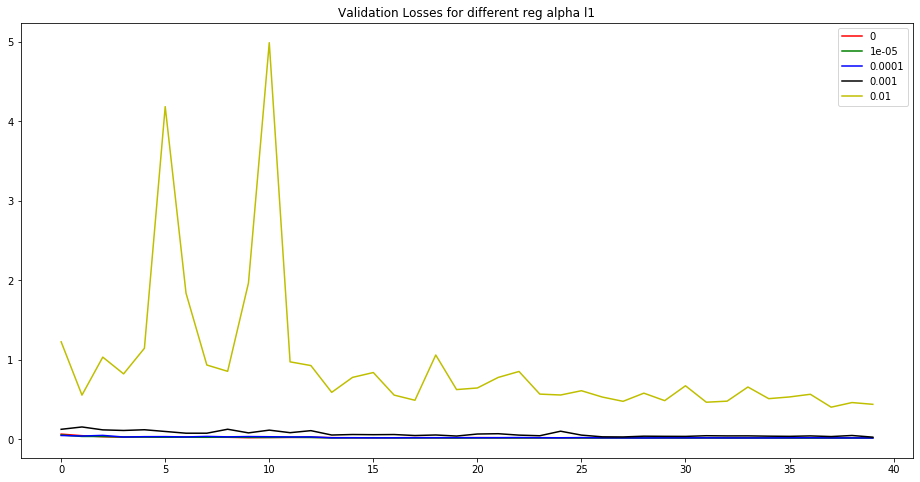

In [38]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3,1e-2]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationLosses'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses for different reg alpha l1')
plt.show()

We can clearly see that reg alpha was 1e-2 was too much and it made the model underfit massively. So, we will ignore this for now and analyse other reg alpha values

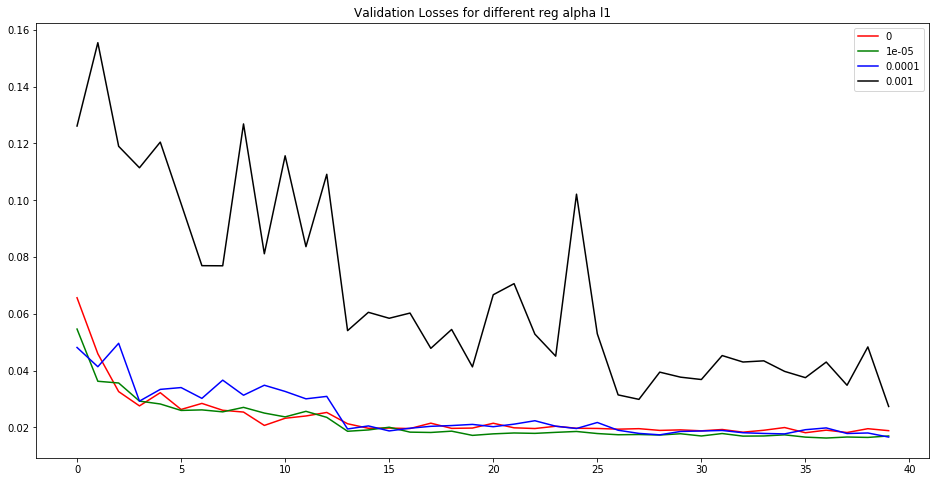

In [39]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationLosses'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses for different reg alpha l1')
plt.show()

From the above curve, it can be seen that reg alpha values of 1e-4 and 1e-5 clearly performed better than 0 l1 penalty(baseline model). This is an indication of model was overfitting initially without l1 penalty. But we can also see that the validation losses was swingly widly with alpha of 1e-4. Let's plot the standard deviation of losses change for different alpha values

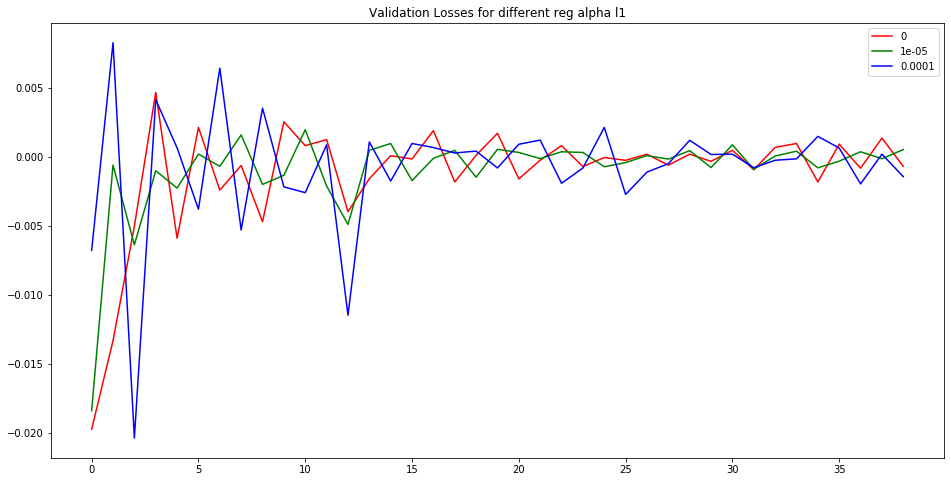

In [42]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  plt.plot(np.diff(np.array(temp['ValidationLosses'])),c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses changes for successive epochs for different reg alpha l1')
plt.show()

No handles with labels found to put in legend.


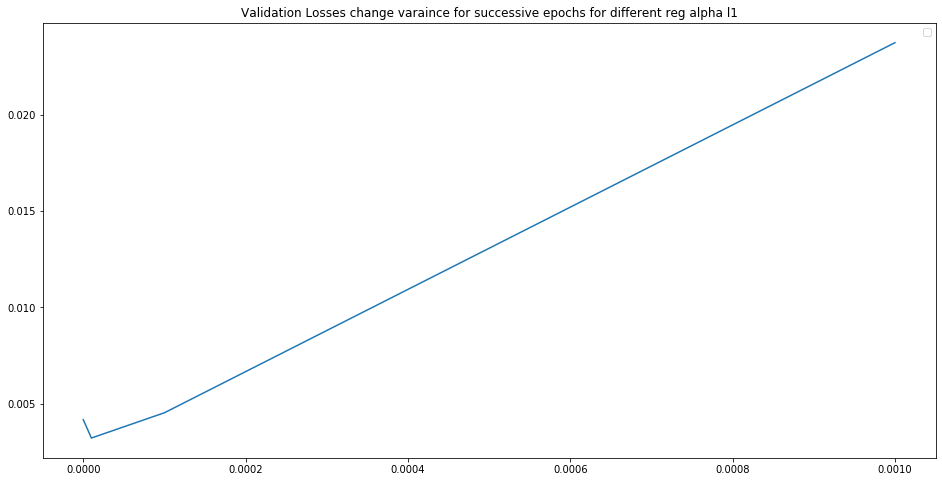

In [46]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
stds=[]
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  stds.append(np.diff(np.array(temp['ValidationLosses'])).std())
plt.plot([0,1e-5,1e-4,1e-3],stds)
plt.legend(loc='best')
plt.title('Validation Losses change varaince for successive epochs for different reg alpha l1')
plt.show()



Above two plots confirmed our analysis that 1e-5 alpha has best accuracy and least standard deviation of loss changes from one epoch to another. We can also track how the spread between training and validation loss behaved for different alpha values 


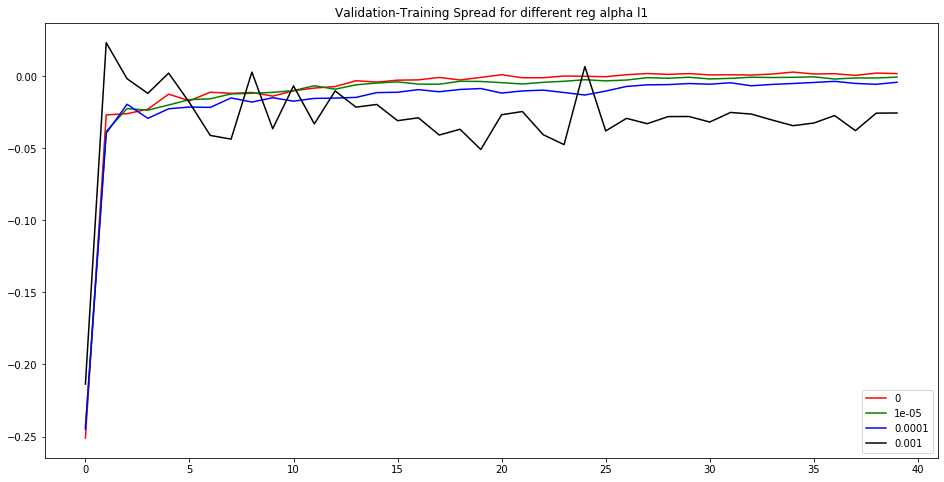

In [47]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  
  plt.plot(np.array(temp['ValidationLosses'])-np.array(temp['TrainingLosses']),c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation-Training Spread for different reg alpha l1')
plt.show()

Above plot tells us that validation loss was lower w.r.t training loss for 1e-4 and 1e-5 in comparison to 0 alpha. This along with previous analysis confirms that the correct alpha value may be within 1e-4 and 1e-5. or may be we could go with 1e-5 as it was more stable(from standard deviation plot). We will freeze 1e-5 for l1 now. 

Let's Plot accuracies now and find out if accuracy metric support the analysis done using loss above

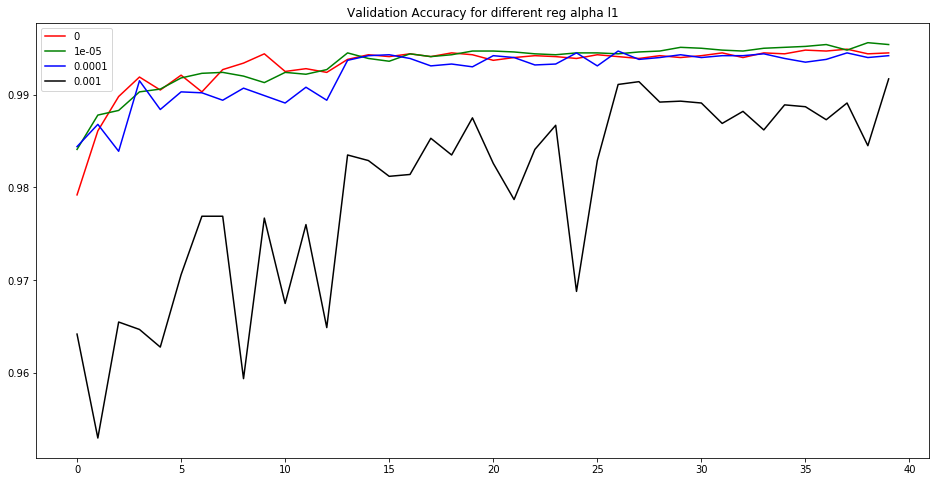

In [48]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationAcc'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Accuracy for different reg alpha l1')
plt.show()

Again from the accuracy plot, we can easily see that 1e-5 alpha value outshines all other values. Interesting point-- 1e-4 value finally achieved lower accuracy value in comparison to 0 reg value. This is in contrast to loss curve. But we also found out that standard deviation of loss change every subsequent epoch was higher for 1e-4. So, it seems that was the right metric to track as it definitely supported our 1e-5 reg alphs value. So, our final value of **l1 alpha= 1e-5**

## L2 regularization

In [23]:
%%time 
trained_models_l2={}
for regl in [0,1e-5,1e-4,1e-3,1e-2,1e-1]:
  trained_models_l2[str(regl)]=train(epochs=40,l2=regl)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.330, Validation Loss:0.054

Training Accuracy:90.452, Validation Accuracy:98.150



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.084, Validation Loss:0.053

Training Accuracy:97.502, Validation Accuracy:98.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.067, Validation Loss:0.043

Training Accuracy:97.965, Validation Accuracy:98.670



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.062, Validation Loss:0.037

Training Accuracy:98.133, Validation Accuracy:98.790



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.057, Validation Loss:0.031

Training Accuracy:98.247, Validation Accuracy:99.080



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.055, Validation Loss:0.031

Training Accuracy:98.352, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.054, Validation Loss:0.028

Training Accuracy:98.365, Validation Accuracy:99.150



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.051, Validation Loss:0.035

Training Accuracy:98.408, Validation Accuracy:98.930



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.049, Validation Loss:0.033

Training Accuracy:98.467, Validation Accuracy:98.970



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.050, Validation Loss:0.033

Training Accuracy:98.495, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.047, Validation Loss:0.034

Training Accuracy:98.548, Validation Accuracy:99.010



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.049, Validation Loss:0.027

Training Accuracy:98.482, Validation Accuracy:99.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.046, Validation Loss:0.032

Training Accuracy:98.628, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.034, Validation Loss:0.020

Training Accuracy:98.963, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.030, Validation Loss:0.018

Training Accuracy:99.102, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.032, Validation Loss:0.018

Training Accuracy:98.998, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.030, Validation Loss:0.023

Training Accuracy:99.092, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.050, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.032, Validation Loss:0.019

Training Accuracy:99.000, Validation Accuracy:99.290



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.031, Validation Loss:0.022

Training Accuracy:99.018, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.060, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.068, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.031, Validation Loss:0.023

Training Accuracy:99.050, Validation Accuracy:99.170



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.032, Validation Loss:0.023

Training Accuracy:99.000, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.007, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.033, Validation Loss:0.019

Training Accuracy:99.035, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.026, Validation Loss:0.018

Training Accuracy:99.208, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.235, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.300, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.290, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.272, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.253, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.323, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.288, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.292, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.257, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.245, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.285, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.293, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.021, Validation Loss:0.017

Training Accuracy:99.368, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.308, Validation Loss:0.052

Training Accuracy:91.058, Validation Accuracy:98.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.080, Validation Loss:0.037

Training Accuracy:97.682, Validation Accuracy:99.000



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.070, Validation Loss:0.038

Training Accuracy:97.920, Validation Accuracy:98.880



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.062, Validation Loss:0.040

Training Accuracy:98.155, Validation Accuracy:98.750



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.058, Validation Loss:0.034

Training Accuracy:98.267, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.055, Validation Loss:0.027

Training Accuracy:98.332, Validation Accuracy:99.130



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.054, Validation Loss:0.037

Training Accuracy:98.382, Validation Accuracy:98.750



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.053, Validation Loss:0.031

Training Accuracy:98.402, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.049, Validation Loss:0.029

Training Accuracy:98.515, Validation Accuracy:99.080



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.049, Validation Loss:0.028

Training Accuracy:98.460, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.049, Validation Loss:0.033

Training Accuracy:98.487, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.049, Validation Loss:0.028

Training Accuracy:98.513, Validation Accuracy:99.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.048, Validation Loss:0.026

Training Accuracy:98.540, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.034, Validation Loss:0.018

Training Accuracy:99.013, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.032, Validation Loss:0.020

Training Accuracy:99.060, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.033, Validation Accuracy:99.300



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.031, Validation Loss:0.019

Training Accuracy:99.035, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.025, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.032, Validation Loss:0.021

Training Accuracy:99.052, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.031, Validation Loss:0.018

Training Accuracy:99.063, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.031, Validation Loss:0.019

Training Accuracy:99.115, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.032, Validation Loss:0.023

Training Accuracy:99.028, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.033, Validation Loss:0.019

Training Accuracy:98.955, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.030, Validation Loss:0.019

Training Accuracy:99.102, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.030, Validation Loss:0.020

Training Accuracy:99.063, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.033, Validation Loss:0.023

Training Accuracy:99.038, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.026, Validation Loss:0.018

Training Accuracy:99.200, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.223, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.268, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.360, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.305, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.273, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.318, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.333, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.283, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.320, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.262, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.285, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.288, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.022, Validation Loss:0.016

Training Accuracy:99.392, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.291, Validation Loss:0.069

Training Accuracy:91.892, Validation Accuracy:97.860



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.081, Validation Loss:0.050

Training Accuracy:97.592, Validation Accuracy:98.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.068, Validation Loss:0.035

Training Accuracy:98.015, Validation Accuracy:98.970



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.063, Validation Loss:0.037

Training Accuracy:98.138, Validation Accuracy:98.790



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.058, Validation Loss:0.033

Training Accuracy:98.248, Validation Accuracy:99.010



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.054, Validation Loss:0.031

Training Accuracy:98.320, Validation Accuracy:99.080



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.053, Validation Loss:0.028

Training Accuracy:98.365, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.052, Validation Loss:0.030

Training Accuracy:98.463, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.051, Validation Loss:0.032

Training Accuracy:98.440, Validation Accuracy:99.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.049, Validation Loss:0.029

Training Accuracy:98.530, Validation Accuracy:99.160



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.049, Validation Loss:0.032

Training Accuracy:98.532, Validation Accuracy:98.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.048, Validation Loss:0.030

Training Accuracy:98.542, Validation Accuracy:99.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.046, Validation Loss:0.024

Training Accuracy:98.580, Validation Accuracy:99.250



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.032, Validation Loss:0.021

Training Accuracy:99.023, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.031, Validation Loss:0.018

Training Accuracy:99.040, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.029, Validation Loss:0.021

Training Accuracy:99.118, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.030, Validation Loss:0.021

Training Accuracy:99.093, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.030, Validation Loss:0.022

Training Accuracy:99.115, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.031, Validation Loss:0.021

Training Accuracy:99.055, Validation Accuracy:99.300



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.031, Validation Loss:0.022

Training Accuracy:99.050, Validation Accuracy:99.280



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.050, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.032, Validation Loss:0.021

Training Accuracy:99.017, Validation Accuracy:99.290



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.033, Validation Loss:0.023

Training Accuracy:98.973, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.093, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.031, Validation Loss:0.019

Training Accuracy:99.087, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.034, Validation Loss:0.022

Training Accuracy:98.980, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.025, Validation Loss:0.017

Training Accuracy:99.238, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.300, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.277, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.265, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.300, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.325, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.323, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.278, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.340, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.320, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.025, Validation Loss:0.016

Training Accuracy:99.297, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.312, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.330, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.022, Validation Loss:0.016

Training Accuracy:99.338, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.293, Validation Loss:0.050

Training Accuracy:91.795, Validation Accuracy:98.580



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.080, Validation Loss:0.066

Training Accuracy:97.710, Validation Accuracy:98.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.069, Validation Loss:0.045

Training Accuracy:98.012, Validation Accuracy:98.780



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.070, Validation Loss:0.045

Training Accuracy:98.030, Validation Accuracy:98.690



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.067, Validation Loss:0.040

Training Accuracy:98.130, Validation Accuracy:98.900



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.067, Validation Loss:0.045

Training Accuracy:98.168, Validation Accuracy:98.770



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.065, Validation Loss:0.036

Training Accuracy:98.142, Validation Accuracy:99.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.065, Validation Loss:0.035

Training Accuracy:98.248, Validation Accuracy:99.070



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.066, Validation Loss:0.043

Training Accuracy:98.135, Validation Accuracy:98.790



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.064, Validation Loss:0.053

Training Accuracy:98.178, Validation Accuracy:98.370



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.064, Validation Loss:0.036

Training Accuracy:98.160, Validation Accuracy:98.950



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.065, Validation Loss:0.036

Training Accuracy:98.132, Validation Accuracy:98.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.061, Validation Loss:0.042

Training Accuracy:98.278, Validation Accuracy:98.720



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.042, Validation Loss:0.023

Training Accuracy:98.867, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.040, Validation Loss:0.025

Training Accuracy:98.928, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.040, Validation Loss:0.023

Training Accuracy:98.942, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.041, Validation Loss:0.023

Training Accuracy:98.923, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.043, Validation Loss:0.029

Training Accuracy:98.853, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.043, Validation Loss:0.025

Training Accuracy:98.772, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.045, Validation Loss:0.028

Training Accuracy:98.778, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.046, Validation Loss:0.032

Training Accuracy:98.762, Validation Accuracy:99.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.044, Validation Loss:0.028

Training Accuracy:98.805, Validation Accuracy:99.250



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.046, Validation Loss:0.031

Training Accuracy:98.783, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.048, Validation Loss:0.026

Training Accuracy:98.673, Validation Accuracy:99.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.046, Validation Loss:0.031

Training Accuracy:98.768, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.046, Validation Loss:0.029

Training Accuracy:98.768, Validation Accuracy:99.170



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.033, Validation Loss:0.021

Training Accuracy:99.122, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.030, Validation Loss:0.020

Training Accuracy:99.248, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.031, Validation Loss:0.018

Training Accuracy:99.253, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.030, Validation Loss:0.021

Training Accuracy:99.235, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.030, Validation Loss:0.018

Training Accuracy:99.245, Validation Accuracy:99.560



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.031, Validation Loss:0.018

Training Accuracy:99.193, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.031, Validation Loss:0.022

Training Accuracy:99.163, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.031, Validation Loss:0.020

Training Accuracy:99.218, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.032, Validation Loss:0.022

Training Accuracy:99.198, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.033, Validation Loss:0.023

Training Accuracy:99.162, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.030, Validation Loss:0.021

Training Accuracy:99.225, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.032, Validation Loss:0.020

Training Accuracy:99.208, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.033, Validation Loss:0.019

Training Accuracy:99.153, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.027, Validation Loss:0.017

Training Accuracy:99.333, Validation Accuracy:99.540



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.357, Validation Loss:0.135

Training Accuracy:90.540, Validation Accuracy:96.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.157, Validation Loss:0.114

Training Accuracy:96.688, Validation Accuracy:97.590



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.150, Validation Loss:0.130

Training Accuracy:96.875, Validation Accuracy:97.740



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.147, Validation Loss:0.092

Training Accuracy:96.943, Validation Accuracy:97.760



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.147, Validation Loss:0.235

Training Accuracy:96.923, Validation Accuracy:93.860



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.145, Validation Loss:0.150

Training Accuracy:97.038, Validation Accuracy:96.550



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.142, Validation Loss:0.219

Training Accuracy:97.145, Validation Accuracy:95.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.149, Validation Loss:0.108

Training Accuracy:96.862, Validation Accuracy:97.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.144, Validation Loss:0.116

Training Accuracy:97.043, Validation Accuracy:97.760



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.142, Validation Loss:0.202

Training Accuracy:97.067, Validation Accuracy:94.870



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.142, Validation Loss:0.106

Training Accuracy:97.038, Validation Accuracy:97.610



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.145, Validation Loss:0.126

Training Accuracy:96.992, Validation Accuracy:97.020



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.144, Validation Loss:0.173

Training Accuracy:97.055, Validation Accuracy:95.880



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.106, Validation Loss:0.062

Training Accuracy:98.027, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.112, Validation Loss:0.089

Training Accuracy:97.957, Validation Accuracy:98.120



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.115, Validation Loss:0.075

Training Accuracy:97.867, Validation Accuracy:98.570



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.113, Validation Loss:0.073

Training Accuracy:97.955, Validation Accuracy:98.740



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.113, Validation Loss:0.071

Training Accuracy:97.918, Validation Accuracy:98.570



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.114, Validation Loss:0.063

Training Accuracy:97.948, Validation Accuracy:98.620



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.113, Validation Loss:0.083

Training Accuracy:97.957, Validation Accuracy:98.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.112, Validation Loss:0.061

Training Accuracy:97.983, Validation Accuracy:98.800



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.114, Validation Loss:0.112

Training Accuracy:97.913, Validation Accuracy:98.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.111, Validation Loss:0.076

Training Accuracy:98.008, Validation Accuracy:98.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.113, Validation Loss:0.078

Training Accuracy:98.023, Validation Accuracy:98.770



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.112, Validation Loss:0.067

Training Accuracy:97.992, Validation Accuracy:98.900



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.112, Validation Loss:0.097

Training Accuracy:97.990, Validation Accuracy:98.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.085, Validation Loss:0.049

Training Accuracy:98.688, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.086, Validation Loss:0.042

Training Accuracy:98.715, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.087, Validation Loss:0.046

Training Accuracy:98.647, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.090, Validation Loss:0.077

Training Accuracy:98.605, Validation Accuracy:98.380



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.091, Validation Loss:0.075

Training Accuracy:98.570, Validation Accuracy:98.620



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.093, Validation Loss:0.054

Training Accuracy:98.512, Validation Accuracy:98.890



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.091, Validation Loss:0.058

Training Accuracy:98.578, Validation Accuracy:98.920



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.093, Validation Loss:0.058

Training Accuracy:98.562, Validation Accuracy:99.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.091, Validation Loss:0.060

Training Accuracy:98.615, Validation Accuracy:98.950



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.091, Validation Loss:0.051

Training Accuracy:98.565, Validation Accuracy:99.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.094, Validation Loss:0.052

Training Accuracy:98.447, Validation Accuracy:99.100



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.091, Validation Loss:0.057

Training Accuracy:98.603, Validation Accuracy:99.010



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.091, Validation Loss:0.051

Training Accuracy:98.598, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.078, Validation Loss:0.037

Training Accuracy:98.948, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:1.174, Validation Loss:1.948

Training Accuracy:74.610, Validation Accuracy:39.080



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.983, Validation Loss:1.390

Training Accuracy:79.113, Validation Accuracy:59.890



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.868, Validation Loss:1.084

Training Accuracy:89.877, Validation Accuracy:71.620



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.817, Validation Loss:1.225

Training Accuracy:91.303, Validation Accuracy:62.860



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.817, Validation Loss:1.063

Training Accuracy:91.227, Validation Accuracy:68.740



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.823, Validation Loss:1.267

Training Accuracy:90.920, Validation Accuracy:61.130



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.820, Validation Loss:2.143

Training Accuracy:91.078, Validation Accuracy:32.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.824, Validation Loss:1.161

Training Accuracy:90.935, Validation Accuracy:80.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.831, Validation Loss:0.925

Training Accuracy:90.460, Validation Accuracy:87.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.824, Validation Loss:1.137

Training Accuracy:90.880, Validation Accuracy:64.890



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.832, Validation Loss:2.430

Training Accuracy:90.555, Validation Accuracy:16.700



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.846, Validation Loss:1.425

Training Accuracy:90.257, Validation Accuracy:58.800



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.848, Validation Loss:1.533

Training Accuracy:90.082, Validation Accuracy:51.200



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.742, Validation Loss:0.569

Training Accuracy:93.322, Validation Accuracy:94.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.737, Validation Loss:0.727

Training Accuracy:93.405, Validation Accuracy:92.250



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.735, Validation Loss:0.712

Training Accuracy:93.668, Validation Accuracy:87.650



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.736, Validation Loss:0.775

Training Accuracy:93.407, Validation Accuracy:91.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.733, Validation Loss:0.619

Training Accuracy:93.642, Validation Accuracy:95.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.737, Validation Loss:0.700

Training Accuracy:93.485, Validation Accuracy:93.760



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.735, Validation Loss:1.242

Training Accuracy:93.593, Validation Accuracy:66.930



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.736, Validation Loss:0.655

Training Accuracy:93.442, Validation Accuracy:94.890



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.730, Validation Loss:0.705

Training Accuracy:93.697, Validation Accuracy:93.690



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.733, Validation Loss:1.640

Training Accuracy:93.597, Validation Accuracy:47.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.738, Validation Loss:0.711

Training Accuracy:93.400, Validation Accuracy:90.730



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.733, Validation Loss:0.684

Training Accuracy:93.672, Validation Accuracy:92.800



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.731, Validation Loss:0.794

Training Accuracy:93.508, Validation Accuracy:92.570



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.683, Validation Loss:0.563

Training Accuracy:95.082, Validation Accuracy:96.900



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.682, Validation Loss:0.658

Training Accuracy:94.987, Validation Accuracy:95.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.681, Validation Loss:0.695

Training Accuracy:95.128, Validation Accuracy:94.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.680, Validation Loss:0.521

Training Accuracy:95.045, Validation Accuracy:97.210



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.679, Validation Loss:0.603

Training Accuracy:95.070, Validation Accuracy:96.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.682, Validation Loss:0.575

Training Accuracy:95.005, Validation Accuracy:97.290



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.679, Validation Loss:0.620

Training Accuracy:95.230, Validation Accuracy:94.750



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.679, Validation Loss:0.669

Training Accuracy:95.133, Validation Accuracy:93.870



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.680, Validation Loss:0.820

Training Accuracy:95.135, Validation Accuracy:86.680



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.680, Validation Loss:0.703

Training Accuracy:95.058, Validation Accuracy:93.180



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.680, Validation Loss:0.734

Training Accuracy:95.017, Validation Accuracy:94.590



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.681, Validation Loss:0.619

Training Accuracy:95.015, Validation Accuracy:96.630



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.680, Validation Loss:0.556

Training Accuracy:95.127, Validation Accuracy:96.790



100%|██████████| 40/40 [00:01<00:00, 23.76it/s]


Epoch:39--> Training Loss:0.650, Validation Loss:0.562

Training Accuracy:96.122, Validation Accuracy:97.080

CPU times: user 33min 19s, sys: 4min 7s, total: 37min 27s
Wall time: 1h 8min 3s


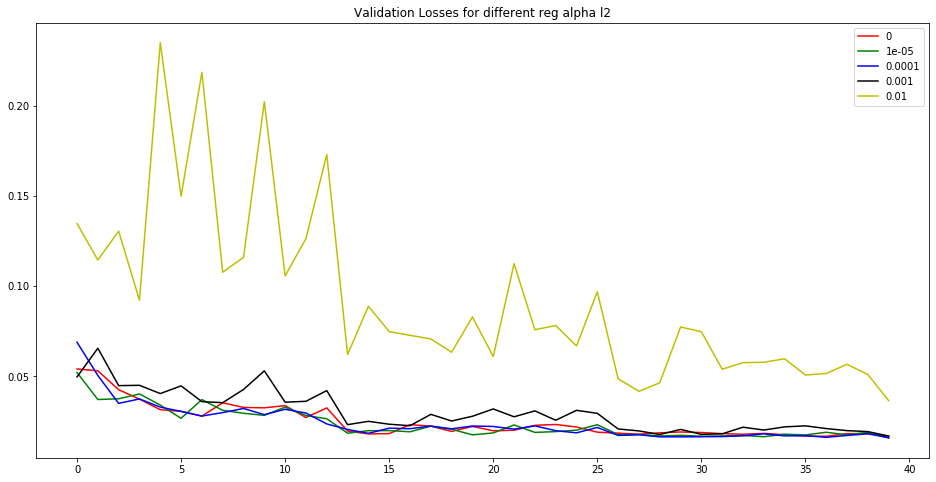

In [24]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3,1e-2]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationLosses'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses for different reg alpha l2')
plt.show()

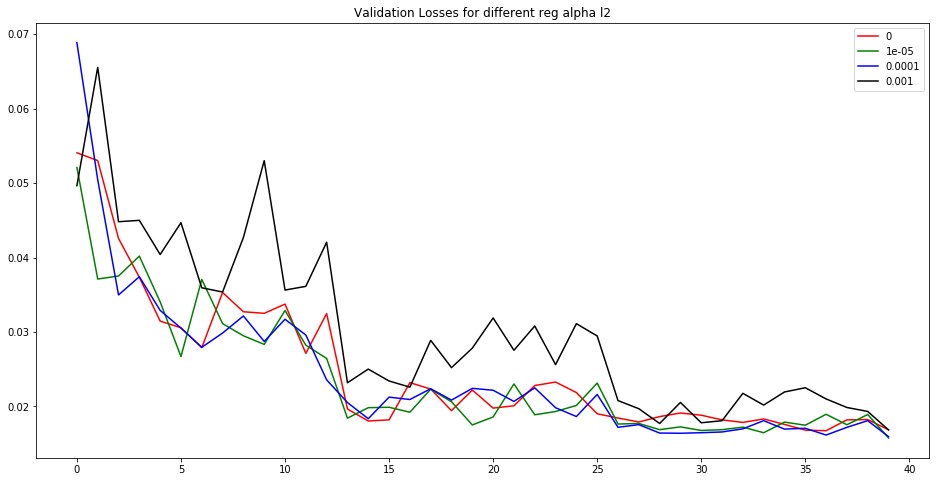

In [26]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationLosses'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses for different reg alpha l2')
plt.show()

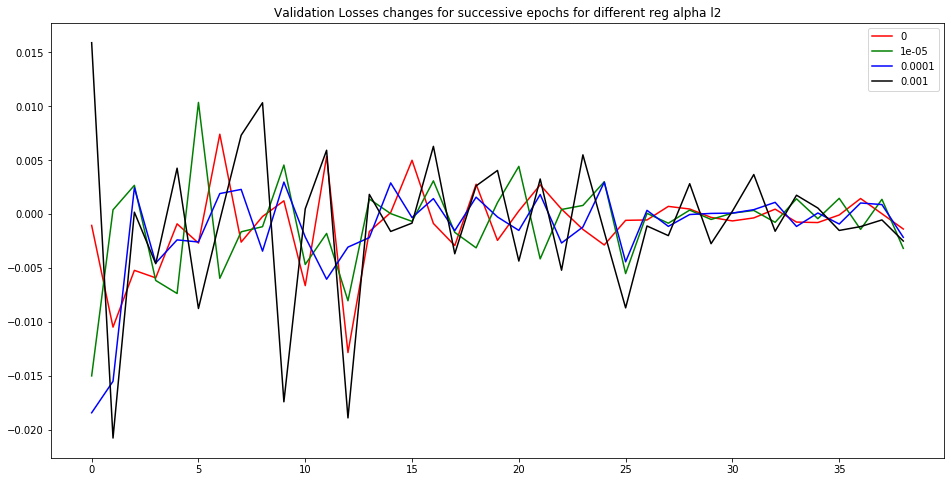

In [32]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  plt.plot(np.diff(np.array(temp['ValidationLosses'])),c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Losses changes for successive epochs for different reg alpha l2')
plt.show()

No handles with labels found to put in legend.


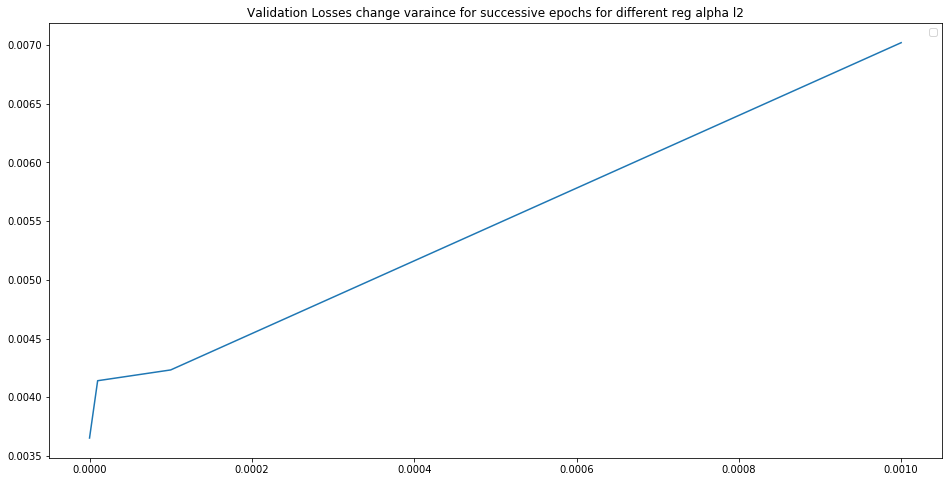

In [31]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
stds=[]
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  stds.append(np.diff(np.array(temp['ValidationLosses'])).std())
plt.plot([0,1e-5,1e-4,1e-3],stds)
plt.legend(loc='best')
plt.title('Validation Losses change varaince for successive epochs for different reg alpha l2')
plt.show()

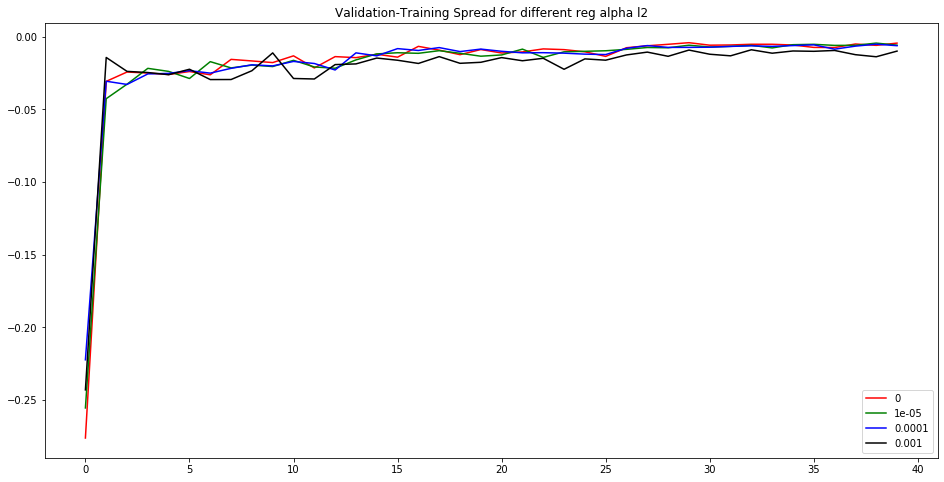

In [30]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  
  plt.plot(np.array(temp['ValidationLosses'])-np.array(temp['TrainingLosses']),c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation-Training Spread for different reg alpha l2')
plt.show()

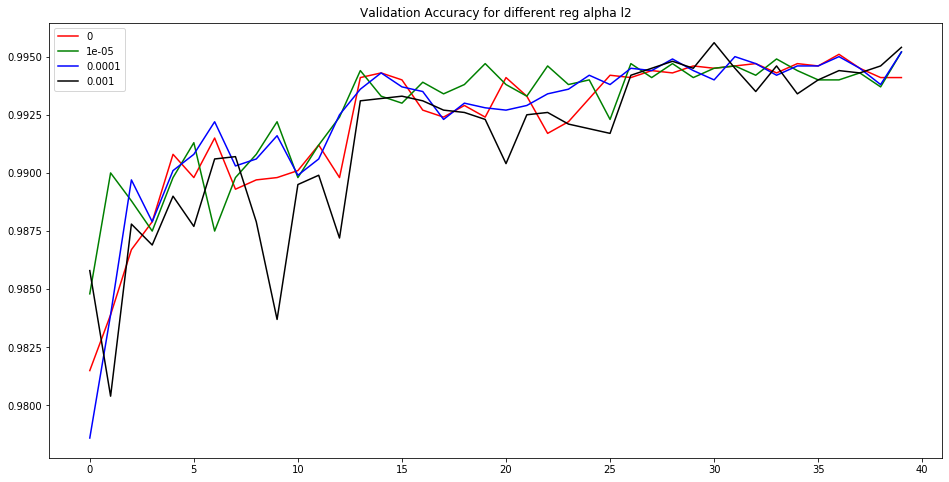

In [35]:
# Let's plot the validation losses for all the reg alpha values we tried
plt.figure(figsize=(16,8))
cmap=['r','g','b','k','y','m']
for i,regl in enumerate([0,1e-5,1e-4,1e-3]):
  key = str(regl)
  temp = trained_models_l2[key]#['ValidationLosses'] 
  plt.plot(temp['ValidationAcc'],c=cmap[i],label=key)
plt.legend(loc='best')
plt.title('Validation Accuracy for different reg alpha l2')
plt.show()

Following similar reasoning as before, we could easily identify that 1e-4 seems to be the best choice for l2 regularization which provides high accuracy and lower loss 

## L2 and L1

In [37]:
%%time 
trained_models_l12={}
for regl1,regl2 in [(1e-6,1e-5),(1e-6,1e-4),(1e-5,1e-5),(1e-5,1e-4)]:
  trained_models_l12[(str(regl1),str(regl2))]=train(epochs=40,l2=regl2,l1=regl1)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.347, Validation Loss:0.070

Training Accuracy:89.872, Validation Accuracy:97.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.080, Validation Loss:0.041

Training Accuracy:97.665, Validation Accuracy:98.670



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.065, Validation Loss:0.032

Training Accuracy:98.082, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.056, Validation Loss:0.032

Training Accuracy:98.297, Validation Accuracy:98.960



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.048, Validation Loss:0.030

Training Accuracy:98.572, Validation Accuracy:98.960



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.047, Validation Loss:0.024

Training Accuracy:98.595, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.042, Validation Loss:0.028

Training Accuracy:98.682, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.039, Validation Loss:0.025

Training Accuracy:98.783, Validation Accuracy:99.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.039, Validation Loss:0.027

Training Accuracy:98.822, Validation Accuracy:99.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.036, Validation Loss:0.024

Training Accuracy:98.935, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.035, Validation Loss:0.025

Training Accuracy:98.903, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.035, Validation Loss:0.022

Training Accuracy:98.938, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.033, Validation Loss:0.024

Training Accuracy:98.992, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.027, Validation Loss:0.021

Training Accuracy:99.132, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.240, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.257, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.298, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.252, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.243, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.278, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.288, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.262, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.305, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.310, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.308, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.308, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.397, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.393, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.378, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.423, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.358, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.392, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.377, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.355, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.423, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.408, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.452, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.398, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.467, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.422, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.308, Validation Loss:0.055

Training Accuracy:91.045, Validation Accuracy:98.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.076, Validation Loss:0.044

Training Accuracy:97.692, Validation Accuracy:98.580



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.060, Validation Loss:0.035

Training Accuracy:98.145, Validation Accuracy:98.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.031

Training Accuracy:98.412, Validation Accuracy:99.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.049, Validation Loss:0.027

Training Accuracy:98.515, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.044, Validation Loss:0.024

Training Accuracy:98.665, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.044, Validation Loss:0.030

Training Accuracy:98.667, Validation Accuracy:99.060



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.042, Validation Loss:0.024

Training Accuracy:98.747, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.039, Validation Loss:0.024

Training Accuracy:98.817, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.039, Validation Loss:0.025

Training Accuracy:98.783, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.035, Validation Loss:0.024

Training Accuracy:98.913, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.034, Validation Loss:0.026

Training Accuracy:98.958, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.034, Validation Loss:0.024

Training Accuracy:98.993, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.027, Validation Loss:0.019

Training Accuracy:99.153, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.263, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.248, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.025, Validation Loss:0.020

Training Accuracy:99.220, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.258, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.307, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.025, Validation Loss:0.020

Training Accuracy:99.208, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.312, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.312, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.275, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.322, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.307, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.313, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.398, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.428, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.393, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.435, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.342, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.019, Validation Loss:0.020

Training Accuracy:99.438, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.367, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.400, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.388, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.398, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.019, Validation Loss:0.020

Training Accuracy:99.378, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.447, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.019, Validation Loss:0.020

Training Accuracy:99.440, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.408, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.298, Validation Loss:0.051

Training Accuracy:91.368, Validation Accuracy:98.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.074, Validation Loss:0.050

Training Accuracy:97.772, Validation Accuracy:98.540



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.060, Validation Loss:0.032

Training Accuracy:98.193, Validation Accuracy:99.020



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.029

Training Accuracy:98.387, Validation Accuracy:99.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.049, Validation Loss:0.032

Training Accuracy:98.518, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.046, Validation Loss:0.028

Training Accuracy:98.513, Validation Accuracy:99.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.044, Validation Loss:0.030

Training Accuracy:98.643, Validation Accuracy:99.100



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.040, Validation Loss:0.026

Training Accuracy:98.745, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.040, Validation Loss:0.025

Training Accuracy:98.825, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.038, Validation Loss:0.023

Training Accuracy:98.805, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.036, Validation Loss:0.022

Training Accuracy:98.877, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.034, Validation Loss:0.020

Training Accuracy:98.880, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.035, Validation Loss:0.023

Training Accuracy:98.892, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.026, Validation Loss:0.020

Training Accuracy:99.167, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.255, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.025, Validation Loss:0.020

Training Accuracy:99.232, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.268, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.238, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.243, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.297, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.265, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.327, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.308, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.308, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.222, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.297, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.021, Validation Loss:0.019

Training Accuracy:99.328, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.373, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.020, Validation Loss:0.020

Training Accuracy:99.352, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.415, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.388, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.433, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.388, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.373, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.019, Validation Loss:0.020

Training Accuracy:99.400, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.397, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.442, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.407, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.380, Validation Accuracy:99.450



100%|██████████| 40/40 [00:02<00:00, 18.63it/s]



Epoch:39--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.423, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.285, Validation Loss:0.054

Training Accuracy:92.053, Validation Accuracy:98.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.075, Validation Loss:0.035

Training Accuracy:97.750, Validation Accuracy:98.940



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.062, Validation Loss:0.037

Training Accuracy:98.168, Validation Accuracy:98.840



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.055, Validation Loss:0.028

Training Accuracy:98.347, Validation Accuracy:99.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.052, Validation Loss:0.025

Training Accuracy:98.410, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.047, Validation Loss:0.027

Training Accuracy:98.625, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.048, Validation Loss:0.026

Training Accuracy:98.560, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.043, Validation Loss:0.024

Training Accuracy:98.782, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.042, Validation Loss:0.023

Training Accuracy:98.705, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.041, Validation Loss:0.019

Training Accuracy:98.778, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.038, Validation Loss:0.025

Training Accuracy:98.818, Validation Accuracy:99.200



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.038, Validation Loss:0.024

Training Accuracy:98.823, Validation Accuracy:99.270



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.037, Validation Loss:0.026

Training Accuracy:98.897, Validation Accuracy:99.210



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.027, Validation Loss:0.017

Training Accuracy:99.147, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.026, Validation Loss:0.019

Training Accuracy:99.238, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.238, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.243, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.025, Validation Loss:0.020

Training Accuracy:99.198, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.262, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.282, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.242, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.275, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.285, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.297, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.285, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.282, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.021, Validation Loss:0.017

Training Accuracy:99.357, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.410, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.407, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.020, Validation Loss:0.016

Training Accuracy:99.377, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.373, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.019, Validation Loss:0.016

Training Accuracy:99.420, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.432, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.383, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.430, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.019, Validation Loss:0.016

Training Accuracy:99.412, Validation Accuracy:99.550



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.019, Validation Loss:0.016

Training Accuracy:99.383, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.020, Validation Loss:0.016

Training Accuracy:99.425, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.473, Validation Accuracy:99.510



100%|██████████| 40/40 [00:01<00:00, 20.37it/s]



Epoch:39--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.455, Validation Accuracy:99.500

CPU times: user 25min, sys: 3min 35s, total: 28min 36s
Wall time: 52min 28s


FINAL MODELS

1. L1 -- 1E-5
2. L2 -- 1E-4
3. L1,L2 -- 1E-5,1E-4

In [56]:
trained_models_base=train(epochs=40,l2=0,l1=0)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.310, Validation Loss:0.058

Training Accuracy:90.808, Validation Accuracy:98.040



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.084, Validation Loss:0.038

Training Accuracy:97.513, Validation Accuracy:98.780



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.066, Validation Loss:0.036

Training Accuracy:98.002, Validation Accuracy:98.840



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.057, Validation Loss:0.027

Training Accuracy:98.248, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.053, Validation Loss:0.026

Training Accuracy:98.342, Validation Accuracy:99.180



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.050, Validation Loss:0.030

Training Accuracy:98.480, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.046, Validation Loss:0.026

Training Accuracy:98.660, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.042, Validation Loss:0.022

Training Accuracy:98.683, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.040, Validation Loss:0.022

Training Accuracy:98.813, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.040, Validation Loss:0.022

Training Accuracy:98.765, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.038, Validation Loss:0.023

Training Accuracy:98.805, Validation Accuracy:99.310



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.036, Validation Loss:0.024

Training Accuracy:98.905, Validation Accuracy:99.290



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.035, Validation Loss:0.024

Training Accuracy:98.895, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.030, Validation Loss:0.018

Training Accuracy:99.108, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.026, Validation Loss:0.017

Training Accuracy:99.185, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.027, Validation Loss:0.016

Training Accuracy:99.168, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.208, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.025, Validation Loss:0.016

Training Accuracy:99.220, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.026, Validation Loss:0.016

Training Accuracy:99.172, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.024, Validation Loss:0.015

Training Accuracy:99.273, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.025, Validation Loss:0.016

Training Accuracy:99.235, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.300, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.248, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.297, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.265, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.238, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.021, Validation Loss:0.016

Training Accuracy:99.355, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.022, Validation Loss:0.016

Training Accuracy:99.312, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.370, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.022, Validation Loss:0.015

Training Accuracy:99.325, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.368, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.337, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.020, Validation Loss:0.015

Training Accuracy:99.375, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.345, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.020, Validation Loss:0.016

Training Accuracy:99.387, Validation Accuracy:99.480



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.020, Validation Loss:0.015

Training Accuracy:99.375, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.365, Validation Accuracy:99.550



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.352, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.021, Validation Loss:0.015

Training Accuracy:99.370, Validation Accuracy:99.520



100%|██████████| 40/40 [00:02<00:00, 17.88it/s]


Epoch:39--> Training Loss:0.019, Validation Loss:0.015

Training Accuracy:99.453, Validation Accuracy:99.500



In [40]:
%%time 
trained_models_l1_final=train(epochs=40,l2=0,l1=1e-5)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.324, Validation Loss:0.051

Training Accuracy:90.627, Validation Accuracy:98.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.075, Validation Loss:0.039

Training Accuracy:97.805, Validation Accuracy:98.820



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.061, Validation Loss:0.039

Training Accuracy:98.132, Validation Accuracy:98.770



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.033

Training Accuracy:98.378, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.049, Validation Loss:0.030

Training Accuracy:98.493, Validation Accuracy:99.080



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.045, Validation Loss:0.027

Training Accuracy:98.665, Validation Accuracy:99.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.043, Validation Loss:0.028

Training Accuracy:98.645, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.043, Validation Loss:0.024

Training Accuracy:98.647, Validation Accuracy:99.280



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.039, Validation Loss:0.031

Training Accuracy:98.827, Validation Accuracy:99.030



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.038, Validation Loss:0.025

Training Accuracy:98.828, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.036, Validation Loss:0.027

Training Accuracy:98.900, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.036, Validation Loss:0.026

Training Accuracy:98.902, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.034, Validation Loss:0.023

Training Accuracy:98.970, Validation Accuracy:99.280



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.026, Validation Loss:0.021

Training Accuracy:99.208, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.235, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.025, Validation Loss:0.021

Training Accuracy:99.192, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.258, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.021

Training Accuracy:99.245, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.278, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.293, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.347, Validation Accuracy:99.330



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.238, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.023, Validation Loss:0.021

Training Accuracy:99.273, Validation Accuracy:99.350



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.287, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.021, Validation Loss:0.021

Training Accuracy:99.323, Validation Accuracy:99.340



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.021, Validation Loss:0.017

Training Accuracy:99.355, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.353, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.368, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.358, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.402, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.405, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.020, Validation Loss:0.019

Training Accuracy:99.387, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.393, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.407, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.378, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.019, Validation Loss:0.019

Training Accuracy:99.405, Validation Accuracy:99.370



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.452, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.019, Validation Loss:0.020

Training Accuracy:99.390, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.442, Validation Accuracy:99.420



100%|██████████| 40/40 [00:02<00:00, 18.81it/s]


Epoch:39--> Training Loss:0.018, Validation Loss:0.019

Training Accuracy:99.443, Validation Accuracy:99.400

CPU times: user 6min 11s, sys: 57.6 s, total: 7min 8s
Wall time: 13min 12s


In [41]:
%%time 
trained_models_l2_final=train(epochs=40,l2=1e-4,l1=0)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.300, Validation Loss:0.056

Training Accuracy:91.748, Validation Accuracy:98.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.074, Validation Loss:0.041

Training Accuracy:97.808, Validation Accuracy:98.800



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.062, Validation Loss:0.035

Training Accuracy:98.132, Validation Accuracy:98.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.031

Training Accuracy:98.428, Validation Accuracy:99.110



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.049, Validation Loss:0.028

Training Accuracy:98.483, Validation Accuracy:99.120



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.045, Validation Loss:0.026

Training Accuracy:98.687, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.041, Validation Loss:0.027

Training Accuracy:98.733, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.041, Validation Loss:0.027

Training Accuracy:98.705, Validation Accuracy:99.250



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.037, Validation Loss:0.024

Training Accuracy:98.868, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.038, Validation Loss:0.026

Training Accuracy:98.850, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.037, Validation Loss:0.028

Training Accuracy:98.900, Validation Accuracy:99.190



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.035, Validation Loss:0.027

Training Accuracy:98.935, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.035, Validation Loss:0.027

Training Accuracy:98.942, Validation Accuracy:99.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.028, Validation Loss:0.020

Training Accuracy:99.165, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.192, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.024, Validation Loss:0.020

Training Accuracy:99.310, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.019

Training Accuracy:99.295, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.277, Validation Accuracy:99.360



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.282, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.023, Validation Loss:0.018

Training Accuracy:99.345, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.023, Validation Loss:0.020

Training Accuracy:99.277, Validation Accuracy:99.380



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.022, Validation Loss:0.019

Training Accuracy:99.325, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.282, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.023, Validation Loss:0.019

Training Accuracy:99.317, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.022, Validation Loss:0.021

Training Accuracy:99.317, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.022, Validation Loss:0.020

Training Accuracy:99.380, Validation Accuracy:99.390



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.018

Training Accuracy:99.400, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.020, Validation Loss:0.017

Training Accuracy:99.407, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.452, Validation Accuracy:99.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.438, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.019, Validation Loss:0.018

Training Accuracy:99.438, Validation Accuracy:99.420



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.437, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.438, Validation Accuracy:99.460



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.433, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.412, Validation Accuracy:99.500



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.018, Validation Loss:0.018

Training Accuracy:99.450, Validation Accuracy:99.400



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.408, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.445, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.435, Validation Accuracy:99.430



100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


Epoch:39--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.427, Validation Accuracy:99.450

CPU times: user 6min 26s, sys: 55.6 s, total: 7min 22s
Wall time: 13min 36s


In [42]:
%%time 
trained_models_l12_final=train(epochs=40,l2=1e-4,l1=1e-5)

  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:0--> Training Loss:0.317, Validation Loss:0.050

Training Accuracy:90.903, Validation Accuracy:98.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.074, Validation Loss:0.033

Training Accuracy:97.817, Validation Accuracy:99.000



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.063, Validation Loss:0.032

Training Accuracy:98.147, Validation Accuracy:99.100



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.053, Validation Loss:0.027

Training Accuracy:98.382, Validation Accuracy:99.230



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.050, Validation Loss:0.027

Training Accuracy:98.515, Validation Accuracy:99.240



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.044, Validation Loss:0.031

Training Accuracy:98.710, Validation Accuracy:99.070



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.044, Validation Loss:0.027

Training Accuracy:98.680, Validation Accuracy:99.260



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.042, Validation Loss:0.027

Training Accuracy:98.728, Validation Accuracy:99.150



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.038, Validation Loss:0.031

Training Accuracy:98.785, Validation Accuracy:99.070



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.040, Validation Loss:0.024

Training Accuracy:98.787, Validation Accuracy:99.200



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:10--> Training Loss:0.036, Validation Loss:0.027

Training Accuracy:98.902, Validation Accuracy:99.130



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.035, Validation Loss:0.021

Training Accuracy:98.905, Validation Accuracy:99.320



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.033, Validation Loss:0.024

Training Accuracy:98.992, Validation Accuracy:99.250



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.027, Validation Loss:0.017

Training Accuracy:99.180, Validation Accuracy:99.450



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.019

Training Accuracy:99.248, Validation Accuracy:99.430



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:15--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.235, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16--> Training Loss:0.024, Validation Loss:0.016

Training Accuracy:99.250, Validation Accuracy:99.490



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17--> Training Loss:0.024, Validation Loss:0.017

Training Accuracy:99.243, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18--> Training Loss:0.024, Validation Loss:0.018

Training Accuracy:99.265, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19--> Training Loss:0.023, Validation Loss:0.017

Training Accuracy:99.245, Validation Accuracy:99.540



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:20--> Training Loss:0.022, Validation Loss:0.017

Training Accuracy:99.343, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.330, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22--> Training Loss:0.022, Validation Loss:0.016

Training Accuracy:99.292, Validation Accuracy:99.540



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.335, Validation Accuracy:99.440



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24--> Training Loss:0.023, Validation Loss:0.016

Training Accuracy:99.277, Validation Accuracy:99.470



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:25--> Training Loss:0.022, Validation Loss:0.018

Training Accuracy:99.303, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26--> Training Loss:0.020, Validation Loss:0.016

Training Accuracy:99.375, Validation Accuracy:99.600



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27--> Training Loss:0.019, Validation Loss:0.017

Training Accuracy:99.433, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.405, Validation Accuracy:99.550



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.432, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:30--> Training Loss:0.019, Validation Loss:0.016

Training Accuracy:99.418, Validation Accuracy:99.560



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31--> Training Loss:0.020, Validation Loss:0.016

Training Accuracy:99.432, Validation Accuracy:99.560



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.453, Validation Accuracy:99.530



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33--> Training Loss:0.018, Validation Loss:0.015

Training Accuracy:99.438, Validation Accuracy:99.610



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.428, Validation Accuracy:99.510



  0%|          | 0/469 [00:00<?, ?it/s]


Current Learning Rate: 0.0026999999999999997

Epoch:35--> Training Loss:0.018, Validation Loss:0.015

Training Accuracy:99.455, Validation Accuracy:99.590



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36--> Training Loss:0.017, Validation Loss:0.016

Training Accuracy:99.495, Validation Accuracy:99.560



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37--> Training Loss:0.018, Validation Loss:0.017

Training Accuracy:99.438, Validation Accuracy:99.520



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38--> Training Loss:0.018, Validation Loss:0.016

Training Accuracy:99.472, Validation Accuracy:99.540



100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Epoch:39--> Training Loss:0.017, Validation Loss:0.016

Training Accuracy:99.470, Validation Accuracy:99.550

CPU times: user 6min 24s, sys: 55.6 s, total: 7min 20s
Wall time: 13min 32s


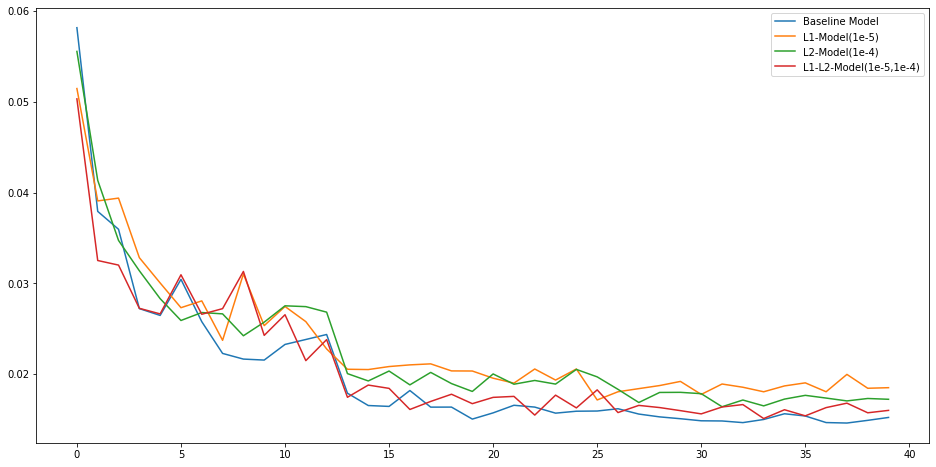

In [58]:
plt.figure(figsize=(16,8))
plt.plot(trained_models_base['ValidationLosses'],label='Baseline Model')
plt.plot(trained_models_l1_final['ValidationLosses'],label='L1-Model(1e-5)')
plt.plot(trained_models_l2_final['ValidationLosses'],label='L2-Model(1e-4)')
plt.plot(trained_models_l12_final['ValidationLosses'],label='L1-L2-Model(1e-5,1e-4)')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Validation Loss vs Epoch')
plt.show()

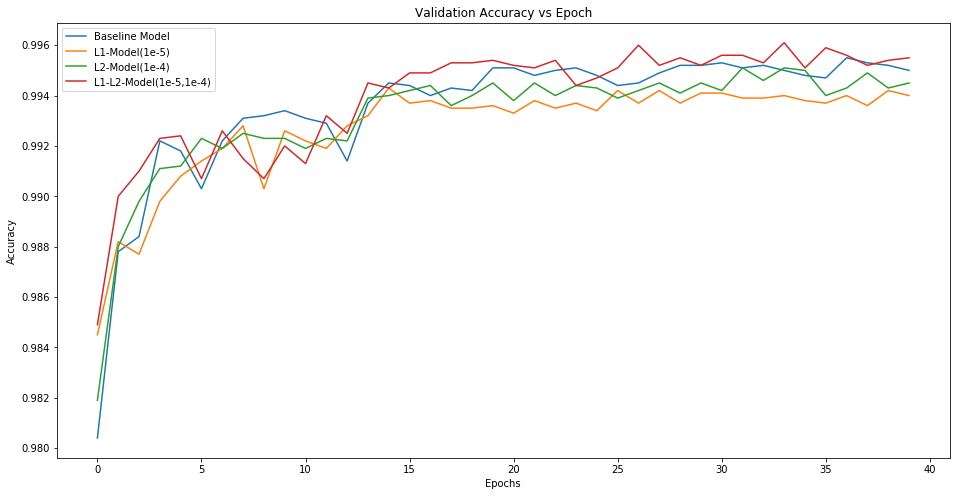

In [60]:
plt.figure(figsize=(16,8))
plt.plot(trained_models_base['ValidationAcc'],label='Baseline Model')
plt.plot(trained_models_l1_final['ValidationAcc'],label='L1-Model(1e-5)')
plt.plot(trained_models_l2_final['ValidationAcc'],label='L2-Model(1e-4)')
plt.plot(trained_models_l12_final['ValidationAcc'],label='L1-L2-Model(1e-5,1e-4)')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.show()

In [61]:
np.max(trained_models_l1_final['ValidationAcc'])

0.9943

## Miss classified examples in L1

In [0]:
def eval(model):
  model.eval()
  with torch.no_grad():
    all_preds=[]
    all_gt=[]
    for xb,yb in test_dl:
      xb,yb = xb.to(dev),yb.to(dev)
      preds = model(xb)
      ypreds = preds.argmax(dim=-1)
      all_preds.extend(ypreds.cpu().numpy().tolist())
      all_gt.extend(yb.cpu().numpy().tolist())
  return all_preds,all_gt

In [104]:
mod = Model(p=0.5,use_bias=False).cuda()
mod.load_state_dict(trained_models_l1_final['model'])
all_preds,all_gt=eval(mod)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
misclassified_l1 = np.where((np.array(all_preds)!=np.array(all_gt)))[0]

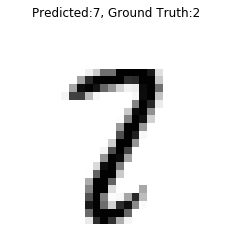

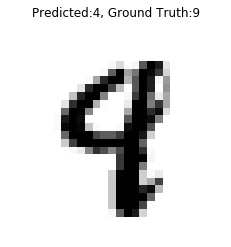

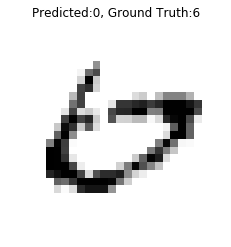

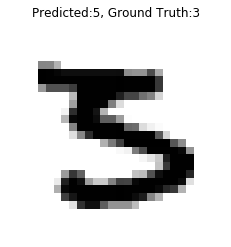

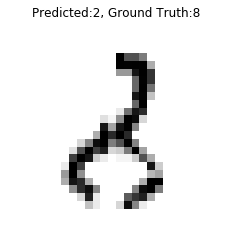

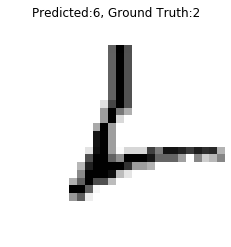

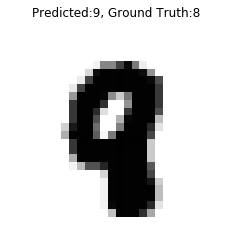

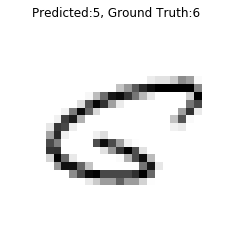

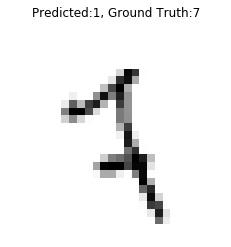

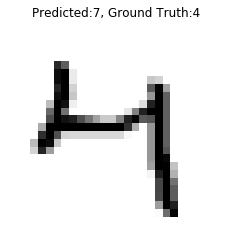

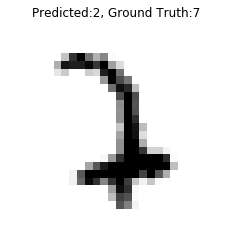

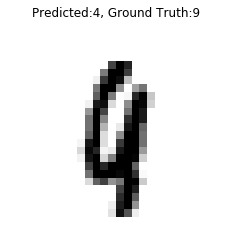

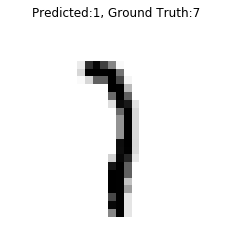

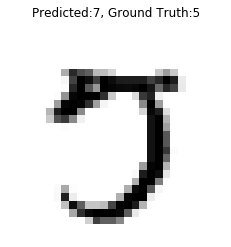

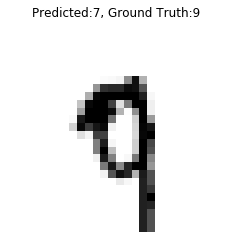

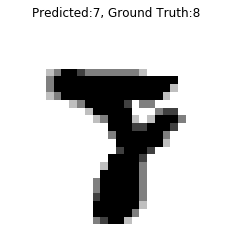

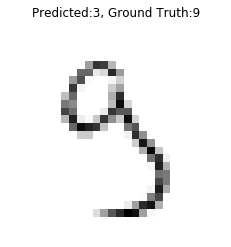

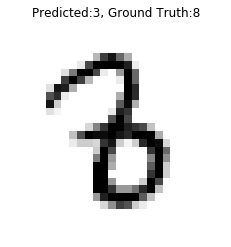

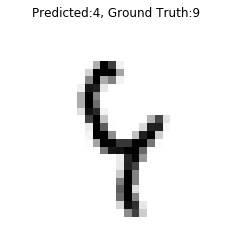

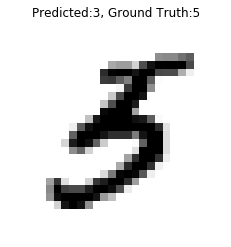

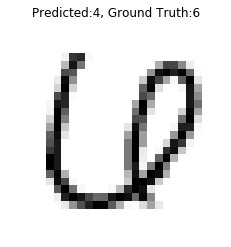

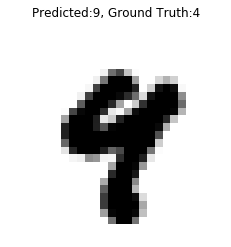

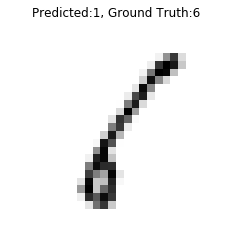

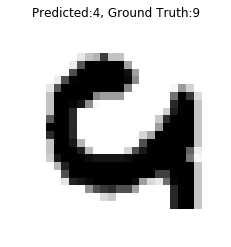

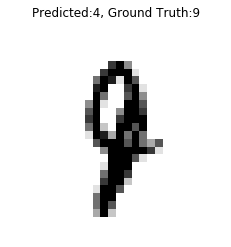

In [106]:
for i in range(25):
  idx=misclassified_l1[i]
  plt.imshow(test_dl.dataset[idx][0].numpy().squeeze(0),cmap='gray_r')
  plt.axis('off')
  plt.title(f'Predicted:{all_preds[idx]}, Ground Truth:{all_gt[idx]}')
  plt.savefig(f'Misclassified L1--{i+1}.png')
  plt.show()

In [107]:
!ls

 data			    'Misclassified L1--22.png'
'Misclassified L1--10.png'  'Misclassified L1--23.png'
'Misclassified L1--11.png'  'Misclassified L1--24.png'
'Misclassified L1--12.png'  'Misclassified L1--25.png'
'Misclassified L1--13.png'  'Misclassified L1--2.png'
'Misclassified L1--14.png'  'Misclassified L1--3.png'
'Misclassified L1--15.png'  'Misclassified L1--4.png'
'Misclassified L1--16.png'  'Misclassified L1--5.png'
'Misclassified L1--17.png'  'Misclassified L1--6.png'
'Misclassified L1--18.png'  'Misclassified L1--7.png'
'Misclassified L1--19.png'  'Misclassified L1--8.png'
'Misclassified L1--1.png'   'Misclassified L1--9.png'
'Misclassified L1--20.png'   sample_data
'Misclassified L1--21.png'


## Misclassified L2

In [100]:
mod = Model(p=0.5,use_bias=False).cuda()
mod.load_state_dict(trained_models_l2_final['model'])
all_preds,all_gt=eval(mod)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
misclassified_l2 = np.where((np.array(all_preds)!=np.array(all_gt)))[0]

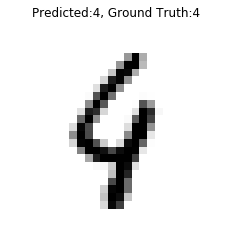

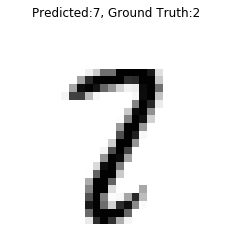

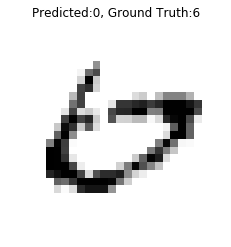

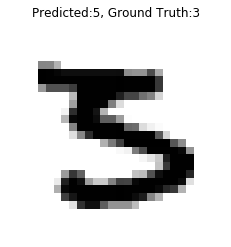

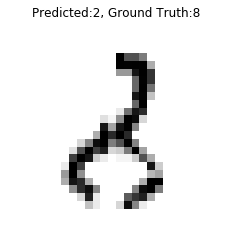

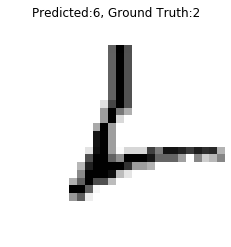

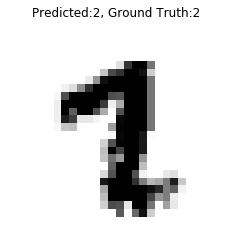

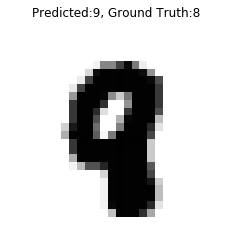

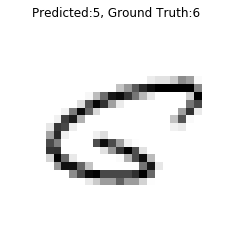

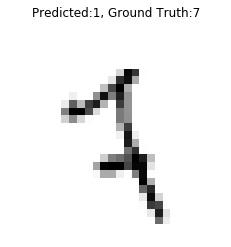

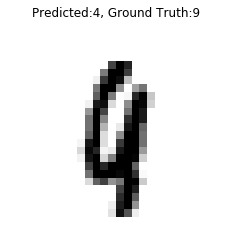

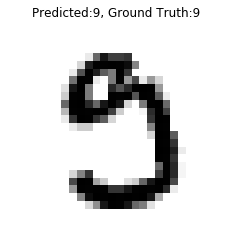

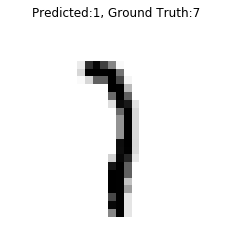

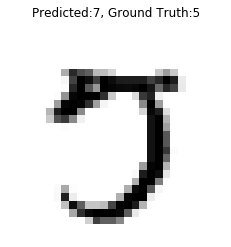

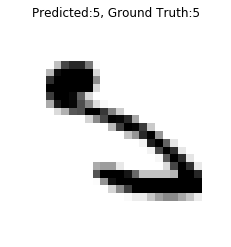

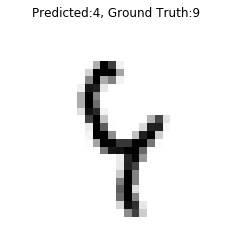

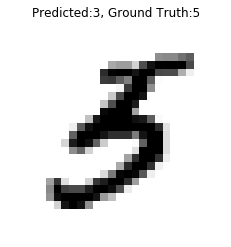

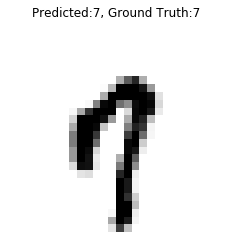

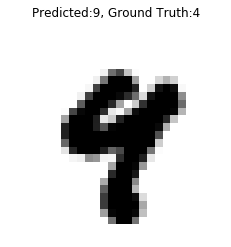

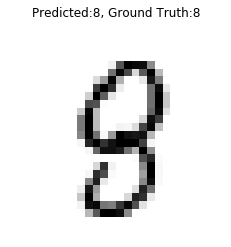

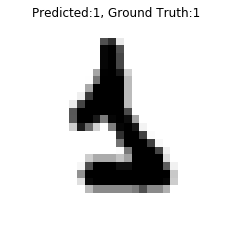

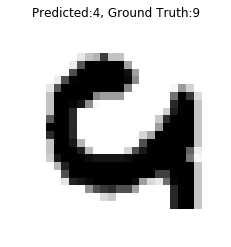

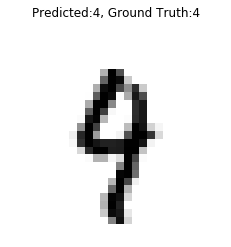

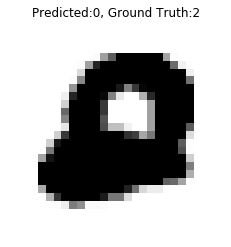

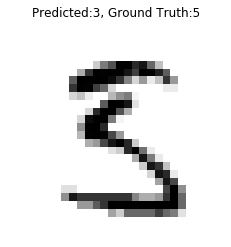

In [108]:
for i in range(25):
  idx=misclassified_l2[i]
  plt.imshow(test_dl.dataset[idx][0].numpy().squeeze(0),cmap='gray_r')
  plt.axis('off')
  plt.title(f'Predicted:{all_preds[idx]}, Ground Truth:{all_gt[idx]}')
  plt.savefig(f'Misclassified L2--{i+1}.png')

  plt.show()

In [109]:
!ls

 data			    'Misclassified L2--10.png'
'Misclassified L1--10.png'  'Misclassified L2--11.png'
'Misclassified L1--11.png'  'Misclassified L2--12.png'
'Misclassified L1--12.png'  'Misclassified L2--13.png'
'Misclassified L1--13.png'  'Misclassified L2--14.png'
'Misclassified L1--14.png'  'Misclassified L2--15.png'
'Misclassified L1--15.png'  'Misclassified L2--16.png'
'Misclassified L1--16.png'  'Misclassified L2--17.png'
'Misclassified L1--17.png'  'Misclassified L2--18.png'
'Misclassified L1--18.png'  'Misclassified L2--19.png'
'Misclassified L1--19.png'  'Misclassified L2--1.png'
'Misclassified L1--1.png'   'Misclassified L2--20.png'
'Misclassified L1--20.png'  'Misclassified L2--21.png'
'Misclassified L1--21.png'  'Misclassified L2--22.png'
'Misclassified L1--22.png'  'Misclassified L2--23.png'
'Misclassified L1--23.png'  'Misclassified L2--24.png'
'Misclassified L1--24.png'  'Misclassified L2--25.png'
'Misclassified L1--25.png'  'Misclassified L2--2.png'
'Misclassified L1--2.png'   